<a href="https://colab.research.google.com/github/GelarehGF/DT-SDG5-8/blob/main/SDG5_8_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q pandas numpy scipy matplotlib networkx \
              python-docx odfpy sentence-transformers openpyxl

!fusermount -u /content/drive || true


from google.colab import drive
drive.mount("/content/drive")


import os
import re
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer, util
from docx import Document
from odf.opendocument import load as odf_load
from odf.element import Element


BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/Files/"
BASE_OUT  = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"


if not os.path.exists(BASE_PATH):
    raise FileNotFoundError(f"مسیر Files پیدا نشد: {BASE_PATH}")


files = [
    f for f in os.listdir(BASE_PATH)
    if f.lower().endswith(".docx")
]


len(files), files[:10]


MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 8.4 MB/s eta 0:00:00
fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

NLP and Graph Theory

In [ ]:


records = []

for f in files:
    fname = f.lower()


    if fname.startswith("sdg5_"):
        sdg = "SDG5"
    elif fname.startswith("sdg8_"):
        sdg = "SDG8"
    else:
        continue

    records.append({
        "File": f,
        "SDG": sdg,
        "Path": os.path.join(BASE_PATH, f)
    })


meta_df = pd.DataFrame(records)


meta_df.shape, meta_df.head()

((269, 3),
             File   SDG                                               Path
 0  SDG8_003.docx  SDG8  /content/drive/MyDrive/Colab Notebooks/DTOSDG5...
 1  SDG8_005.docx  SDG8  /content/drive/MyDrive/Colab Notebooks/DTOSDG5...
 2  SDG8_008.docx  SDG8  /content/drive/MyDrive/Colab Notebooks/DTOSDG5...
 3  SDG8_009.docx  SDG8  /content/drive/MyDrive/Colab Notebooks/DTOSDG5...
 4  SDG8_010.docx  SDG8  /content/drive/MyDrive/Colab Notebooks/DTOSDG5...)

In [ ]:

def read_docx_text(path):
    try:
        doc = Document(path)
        parts = [p.text for p in doc.paragraphs if p.text]
        return " ".join(parts)
    except:
        return ""


texts = []

for _, r in meta_df.iterrows():
    text = read_docx_text(r["Path"])

    texts.append({
        "File": r["File"],
        "SDG": r["SDG"],
        "Text": text
    })

text_df = pd.DataFrame(texts)


text_df.shape, text_df.head()

((269, 3),
             File   SDG                                               Text
 0  SDG8_003.docx  SDG8  Does artificial intelligence affect firms’ inn...
 1  SDG8_005.docx  SDG8  S I L E S I A NU N I V E R S I T YO FT E C H N...
 2  SDG8_008.docx  SDG8   ISSN: 1795-6889  https://ht.csr-pub.eu       ...
 3  SDG8_009.docx  SDG8  Managers' Attitudes on The Use of Artificial I...
 4  SDG8_010.docx  SDG8  VOICE WITHOUT REPRESENTATION: WORKER VOICE IN ...)

In [ ]:


DT_THEORIES = {
    "TOE": "Technology Organization Environment framework for digital transformation readiness and adoption",
    "TAM": "Technology Acceptance Model focusing on perceived usefulness and perceived ease of use",
    "UTAUT": "Unified Theory of Acceptance and Use of Technology explaining user adoption and usage behavior",
    "Dynamic Capabilities": "Dynamic capabilities theory focusing on sensing seizing and transforming under digital change",
    "RBV": "Resource Based View emphasizing competitive advantage through valuable organizational resources",
    "STS": "Socio Technical Systems theory emphasizing joint optimization of social and technical systems",
    "DigComp": "Digital competence framework focusing on skills literacy and digital capability development",
    "Just Digital": "Just Digital framework focusing on fairness inclusion equity and digital justice",
    "Stakeholder": "Stakeholder theory emphasizing value creation for multiple stakeholders",
    "Paradox": "Paradox theory focusing on managing tensions contradictions and competing demands"
}

theory_names = list(DT_THEORIES.keys())
theory_texts = list(DT_THEORIES.values())

In [ ]:


theory_embeddings = model.encode(
    theory_texts,
    normalize_embeddings=True
)

In [ ]:


from sentence_transformers import util
import numpy as np

def dominant_dt_theory(text):

    if not isinstance(text, str) or len(text.strip()) < 100:
        return None, {}


    text_emb = model.encode(text, normalize_embeddings=True)


    sims = util.cos_sim(text_emb, theory_embeddings).cpu().numpy()[0]

    scores = dict(zip(theory_names, sims))


    dominant = max(scores, key=scores.get)

    return dominant, scores

In [ ]:


rows = []

for _, r in text_df.iterrows():
    dom_theory, scores = dominant_dt_theory(r["Text"])

    row = {
        "File": r["File"],
        "SDG": r["SDG"],
        "Dominant_DT_Theory": dom_theory
    }


    for k, v in scores.items():
        row[f"Score_{k}"] = v

    rows.append(row)

final_df = pd.DataFrame(rows)


final_df.shape, final_df.head()

((269, 13),
             File   SDG    Dominant_DT_Theory  Score_TOE  Score_TAM  \
 0  SDG8_003.docx  SDG8  Dynamic Capabilities   0.150772   0.095876   
 1  SDG8_005.docx  SDG8                   TOE   0.392667   0.256806   
 2  SDG8_008.docx  SDG8  Dynamic Capabilities   0.065701   0.093956   
 3  SDG8_009.docx  SDG8                   RBV   0.280677   0.257417   
 4  SDG8_010.docx  SDG8                   RBV   0.213892   0.160783   
 
    Score_UTAUT  Score_Dynamic Capabilities  Score_RBV  Score_STS  \
 0     0.066254                    0.214053   0.124091   0.174199   
 1     0.306468                    0.344349   0.221807   0.293295   
 2     0.062746                    0.159525   0.131517   0.087841   
 3     0.222686                    0.219277   0.309437   0.277103   
 4     0.134898                    0.199397   0.241720   0.151346   
 
    Score_DigComp  Score_Just Digital  Score_Stakeholder  Score_Paradox  
 0       0.198795            0.116218           0.036695       0.05848

In [ ]:


output_path = os.path.join(
    BASE_OUT,
    "DT_Theory_by_SDG_from_Filename.csv"
)

final_df.to_csv(output_path, index=False)

output_path

'/content/drive/MyDrive/Colab Notebooks/DTOSDG58/DT_Theory_by_SDG_from_Filename.csv'

In [ ]:


sdg5_table = (
    final_df[final_df["SDG"] == "SDG5"]
    ["Dominant_DT_Theory"]
    .value_counts()
    .reset_index()
)

sdg5_table.columns = ["DT_Theory", "Count"]

sdg5_table["Percent"] = (
    sdg5_table["Count"] / sdg5_table["Count"].sum() * 100
).round(1)

sdg5_table

DT_Theory  Count  Percent
0          Just Digital     34     29.6
1               DigComp     25     21.7
2                   TOE     24     20.9
3                   TAM     11      9.6
4                   STS      7      6.1
5                 UTAUT      5      4.3
6           Stakeholder      3      2.6
7                   RBV      3      2.6
8  Dynamic Capabilities      2      1.7
9               Paradox      1      0.9

In [ ]:


sdg8_table = (
    final_df[final_df["SDG"] == "SDG8"]
    ["Dominant_DT_Theory"]
    .value_counts()
    .reset_index()
)

sdg8_table.columns = ["DT_Theory", "Count"]

sdg8_table["Percent"] = (
    sdg8_table["Count"] / sdg8_table["Count"].sum() * 100
).round(1)

sdg8_table

DT_Theory  Count  Percent
0  Dynamic Capabilities     36     23.7
1                   TOE     30     19.7
2                   STS     27     17.8
3               DigComp     14      9.2
4                   RBV     13      8.6
5                 UTAUT      9      5.9
6                   TAM      8      5.3
7          Just Digital      8      5.3
8           Stakeholder      5      3.3
9               Paradox      2      1.3

In [ ]:


comparison_table = pd.merge(
    sdg5_table,
    sdg8_table,
    on="DT_Theory",
    how="outer",
    suffixes=("_SDG5", "_SDG8")
).fillna(0)

comparison_table = comparison_table.sort_values(
    ["Count_SDG8", "Count_SDG5"],
    ascending=False
)

comparison_table

DT_Theory  Count_SDG5  Percent_SDG5  Count_SDG8  Percent_SDG8
1  Dynamic Capabilities           2           1.7          36          23.7
8                   TOE          24          20.9          30          19.7
5                   STS           7           6.1          27          17.8
0               DigComp          25          21.7          14           9.2
4                   RBV           3           2.6          13           8.6
9                 UTAUT           5           4.3           9           5.9
2          Just Digital          34          29.6           8           5.3
7                   TAM          11           9.6           8           5.3
6           Stakeholder           3           2.6           5           3.3
3               Paradox           1           0.9           2           1.3

In [ ]:


sdg5_table.to_csv(
    os.path.join(BASE_OUT, "Table_DT_Theory_Distribution_SDG5.csv"),
    index=False
)

sdg8_table.to_csv(
    os.path.join(BASE_OUT, "Table_DT_Theory_Distribution_SDG8.csv"),
    index=False
)

comparison_table.to_csv(
    os.path.join(BASE_OUT, "Table_DT_Theory_Comparison_SDG5_SDG8.csv"),
    index=False
)

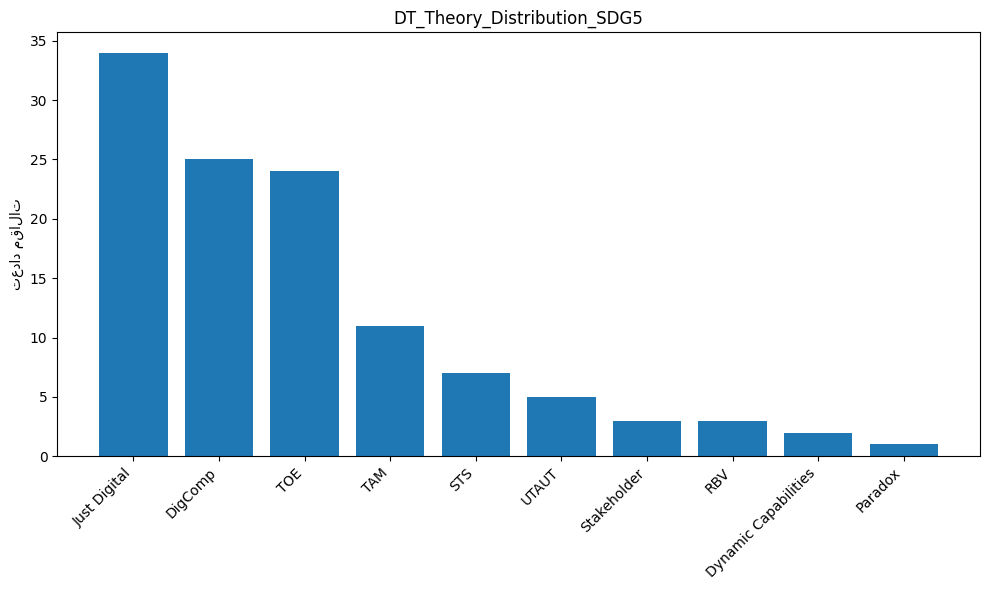

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.bar(
    sdg5_table["DT_Theory"],
    sdg5_table["Count"]
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("تعداد مقالات")
plt.title("DT_Theory_Distribution_SDG5")

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Bar_DT_Theory_Distribution_SDG5.png"),
    dpi=300
)
plt.show()

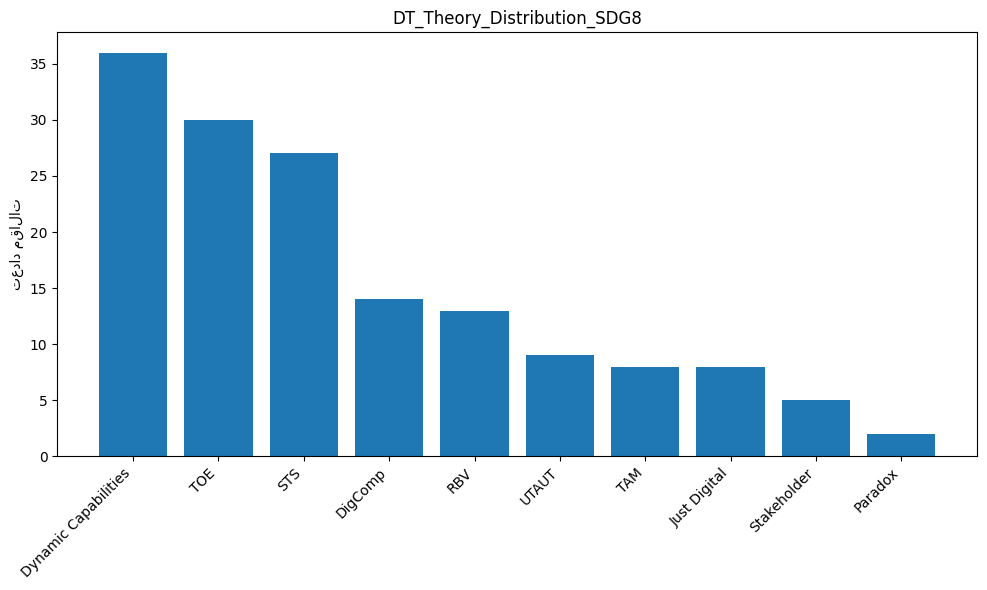

In [ ]:


plt.figure(figsize=(10, 6))

plt.bar(
    sdg8_table["DT_Theory"],
    sdg8_table["Count"]
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("تعداد مقالات")
plt.title("DT_Theory_Distribution_SDG8")

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Bar_DT_Theory_Distribution_SDG8.png"),
    dpi=300
)
plt.show()

In [ ]:


import itertools
import networkx as nx

theory_cols = [c for c in final_df.columns if c.startswith("Score_")]

co_occurrence = {}

for _, row in final_df.iterrows():
    # نظریه‌هایی که امتیاز نسبتاً معنادار دارند
    active_theories = [
        col.replace("Score_", "")
        for col in theory_cols
        if row[col] >= 0.15
    ]

    for t1, t2 in itertools.combinations(active_theories, 2):
        key = tuple(sorted([t1, t2]))
        co_occurrence[key] = co_occurrence.get(key, 0) + 1

In [ ]:


G = nx.Graph()

for (t1, t2), w in co_occurrence.items():
    G.add_edge(t1, t2, weight=w)

centrality_df = pd.DataFrame({
    "DT_Theory": list(G.nodes()),
    "Degree": [nx.degree_centrality(G)[n] for n in G.nodes()],
    "Betweenness": [nx.betweenness_centrality(G, weight="weight")[n] for n in G.nodes()],
    "Closeness": [nx.closeness_centrality(G)[n] for n in G.nodes()],
    "Strength": [G.degree(n, weight="weight") for n in G.nodes()]
})

centrality_df.sort_values("Strength", ascending=False)

DT_Theory  Degree  Betweenness  Closeness  Strength
1                   TOE     1.0     0.000000        1.0      1348
0  Dynamic Capabilities     1.0     0.000000        1.0      1312
3               DigComp     1.0     0.000000        1.0      1204
4                   TAM     1.0     0.000000        1.0      1083
7          Just Digital     1.0     0.000000        1.0      1058
5                 UTAUT     1.0     0.000000        1.0      1050
2                   STS     1.0     0.000000        1.0      1024
6                   RBV     1.0     0.000000        1.0       913
8           Stakeholder     1.0     0.000000        1.0       730
9               Paradox     1.0     0.833333        1.0       456

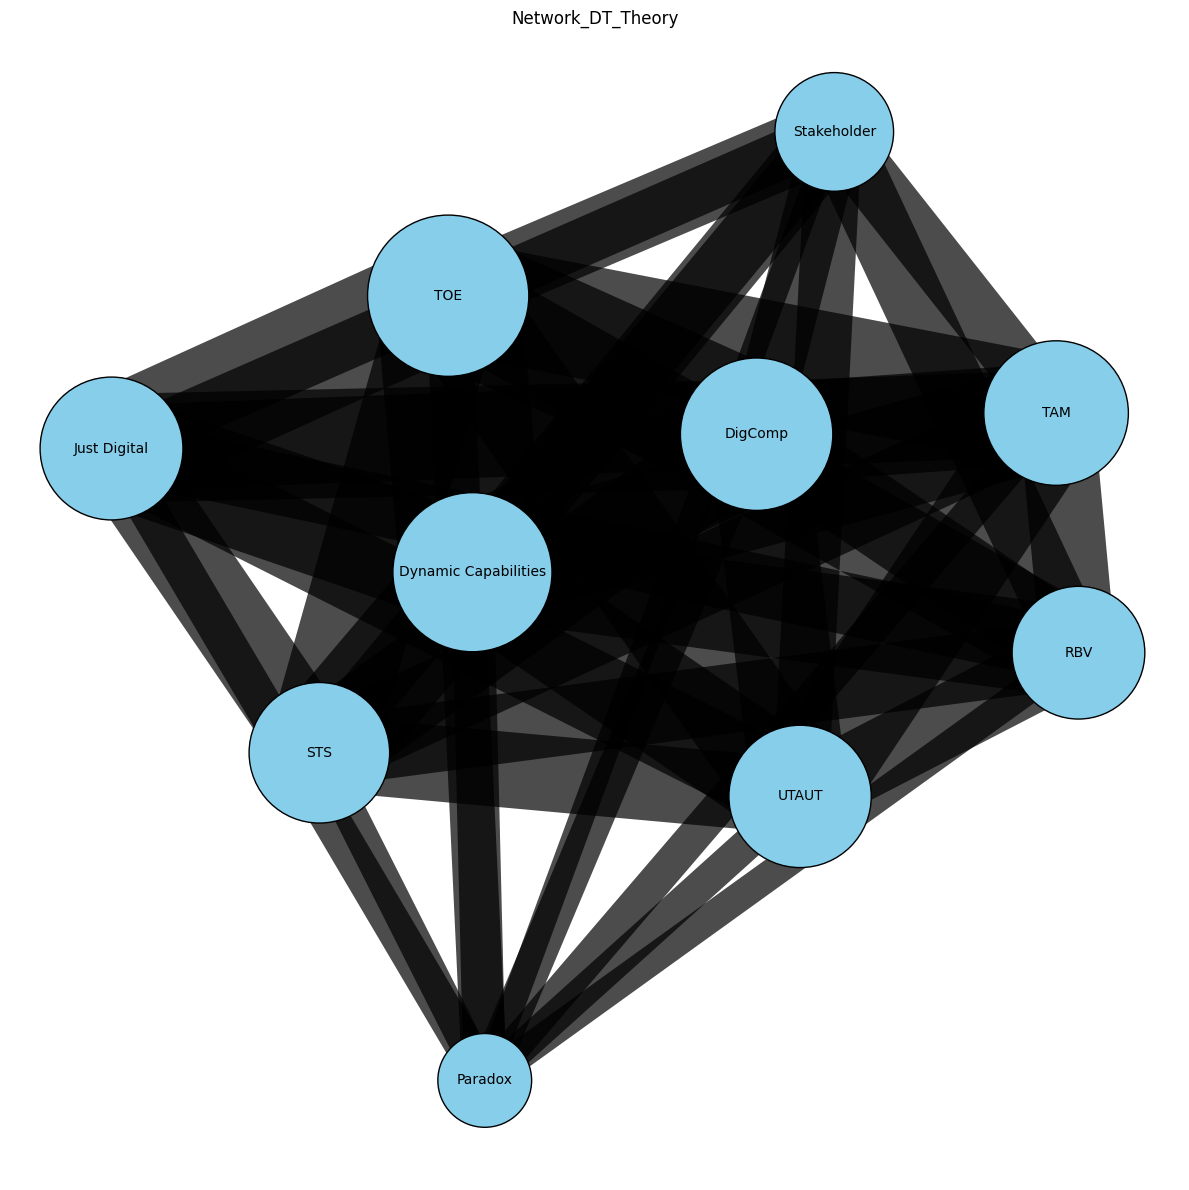

In [ ]:


plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, seed=42)

node_sizes = [
    centrality_df.set_index("DT_Theory").loc[n, "Strength"] * 10
    for n in G.nodes()
]

nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color="skyblue",
    edgecolors="black"
)

nx.draw_networkx_edges(
    G,
    pos,
    width=[G[u][v]["weight"] / 2 for u, v in G.edges()],
    alpha=0.7
)

nx.draw_networkx_labels(
    G,
    pos,
    font_size=10
)

plt.title("Network_DT_Theory")
plt.axis("off")

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Network_DT_Theory_NLP.png"),
    dpi=300
)
plt.show()

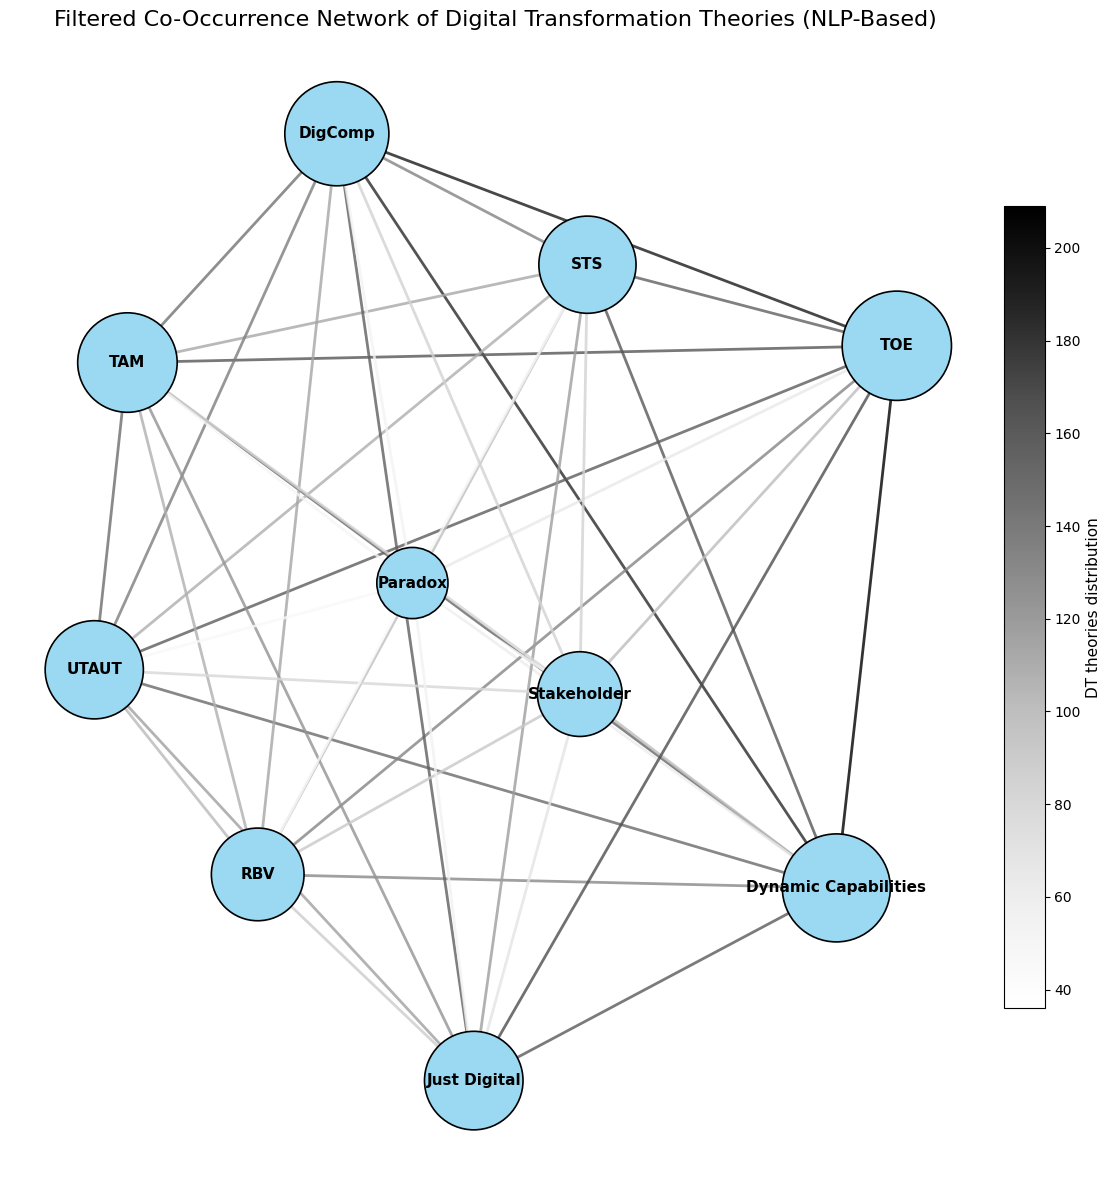

In [ ]:


import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np


EDGE_THRESHOLD = 15

edges_filtered = {
    (t1, t2): w
    for (t1, t2), w in co_occurrence.items()
    if w >= EDGE_THRESHOLD
}


Gf = nx.Graph()
for (t1, t2), w in edges_filtered.items():
    Gf.add_edge(t1, t2, weight=w)


strength_map = {
    n: Gf.degree(n, weight="weight")
    for n in Gf.nodes()
}


pos = nx.kamada_kawai_layout(Gf)


node_sizes = [
    800 + strength_map[n] * 4
    for n in Gf.nodes()
]


edge_weights = np.array(
    [Gf[u][v]["weight"] for u, v in Gf.edges()]
)

norm = mpl.colors.Normalize(
    vmin=edge_weights.min(),
    vmax=edge_weights.max()
)

edge_colors = [
    mpl.cm.Greys(norm(Gf[u][v]["weight"]))
    for u, v in Gf.edges()
]


fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_nodes(
    Gf,
    pos,
    node_size=node_sizes,
    node_color="#9ad9f1",
    edgecolors="black",
    linewidths=1.2,
    ax=ax
)

nx.draw_networkx_edges(
    Gf,
    pos,
    edge_color=edge_colors,
    width=2.0,
    alpha=0.8,
    ax=ax
)

nx.draw_networkx_labels(
    Gf,
    pos,
    font_size=11,
    font_weight="bold",
    ax=ax
)

# نوار رنگ برای شدت یال‌ها
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.Greys, norm=norm)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=ax,
    shrink=0.7,
    pad=0.02
)
cbar.set_label(
    "DT theories distribution",
    fontsize=11
)

ax.set_title(
    "Filtered Co-Occurrence Network of Digital Transformation Theories (NLP-Based)",
    fontsize=16
)

ax.axis("off")
plt.tight_layout()

plt.savefig(
    os.path.join(BASE_OUT, "Network_DT_Theory_NLP_Readable.png"),
    dpi=300
)

plt.show()

In [ ]:


import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import os


theory_cols = [c for c in final_df.columns if c.startswith("Score_")]
theory_names = [c.replace("Score_", "") for c in theory_cols]

# ساخت هم‌وقوعی نظریه‌ها بر اساس آستانه
CO_THRESHOLD = 0.15

co_occurrence = {}

for _, row in final_df.iterrows():
    active = [
        col.replace("Score_", "")
        for col in theory_cols
        if row[col] >= CO_THRESHOLD
    ]
    for t1, t2 in itertools.combinations(active, 2):
        key = tuple(sorted([t1, t2]))
        co_occurrence[key] = co_occurrence.get(key, 0) + 1

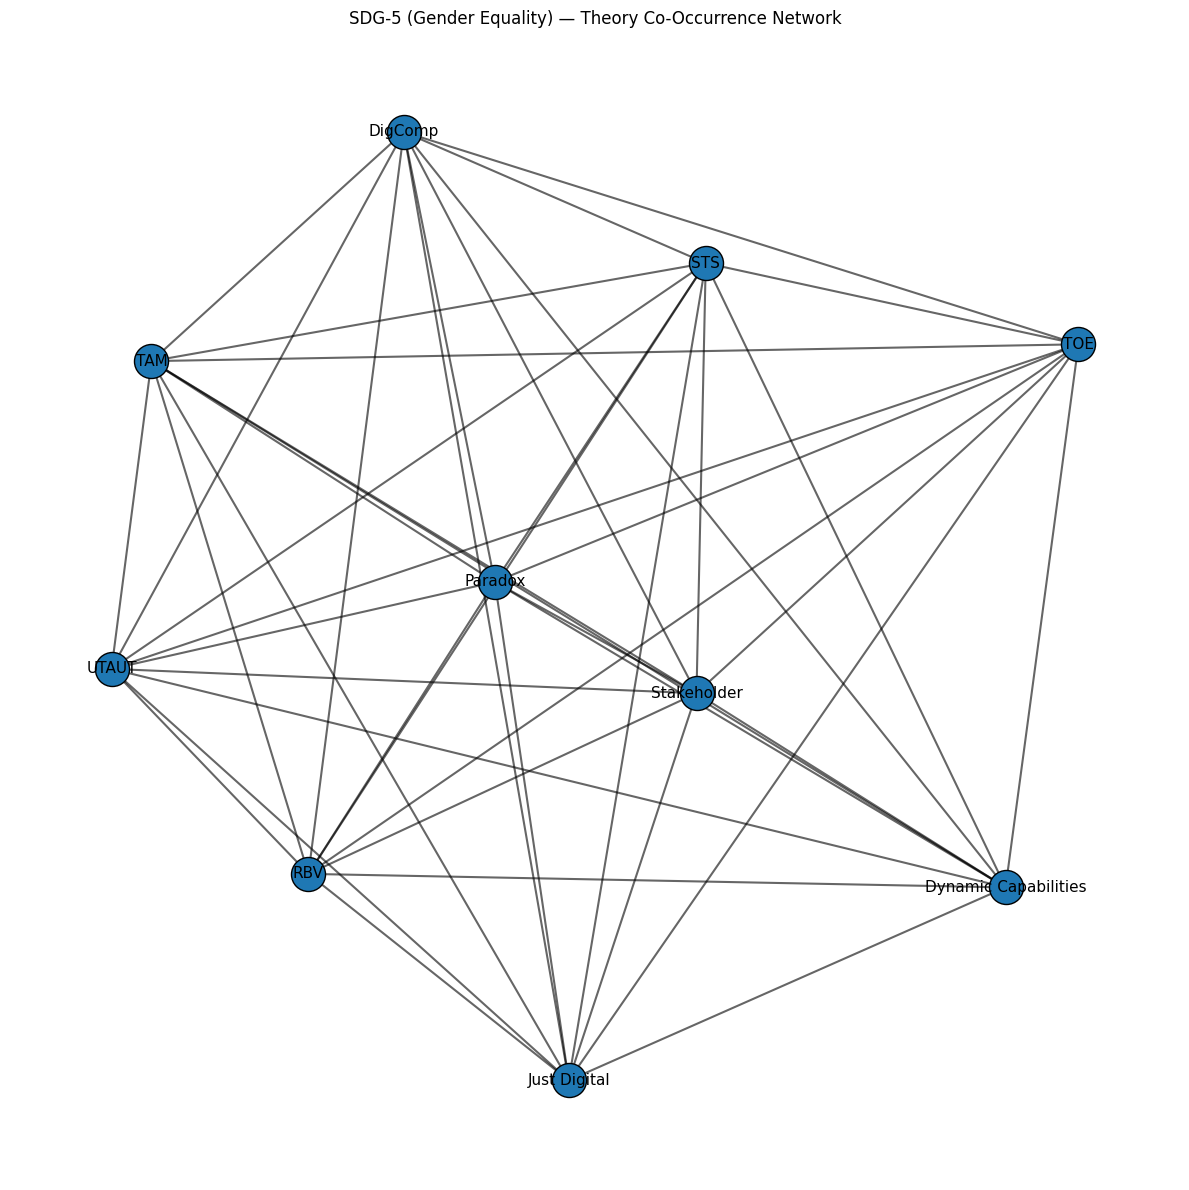

In [ ]:


G5 = nx.Graph()

for (t1, t2), w in co_occurrence.items():
    G5.add_edge(t1, t2, weight=w)

pos = nx.kamada_kawai_layout(G5)

plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(
    G5, pos,
    node_size=600,
    node_color="#1f78b4",
    edgecolors="black"
)

nx.draw_networkx_edges(
    G5, pos,
    width=1.5,
    alpha=0.6
)

nx.draw_networkx_labels(G5, pos, font_size=11)

plt.title("SDG-5 (Gender Equality) — Theory Co-Occurrence Network")
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_OUT, "Figure_SDG5_Theory_Network.png"), dpi=300)
plt.show()

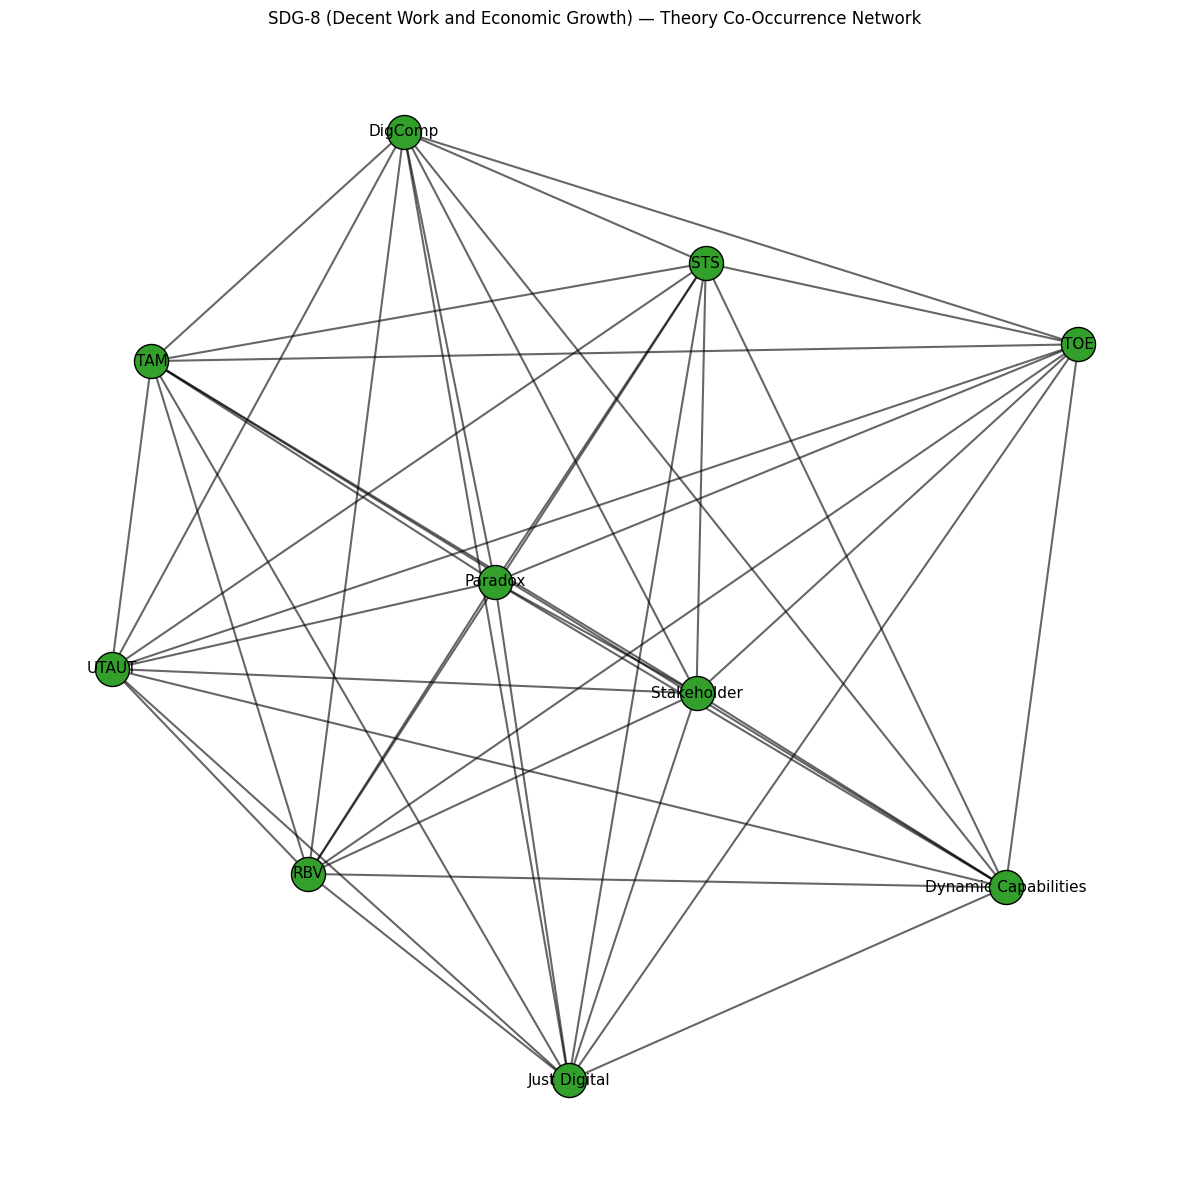

In [ ]:


G8 = nx.Graph()

for (t1, t2), w in co_occurrence.items():
    G8.add_edge(t1, t2, weight=w)

pos = nx.kamada_kawai_layout(G8)

plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(
    G8, pos,
    node_size=600,
    node_color="#33a02c",
    edgecolors="black"
)

nx.draw_networkx_edges(
    G8, pos,
    width=1.5,
    alpha=0.6
)

nx.draw_networkx_labels(G8, pos, font_size=11)

plt.title("SDG-8 (Decent Work and Economic Growth) — Theory Co-Occurrence Network")
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_OUT, "Figure_SDG8_Theory_Network.png"), dpi=300)
plt.show()

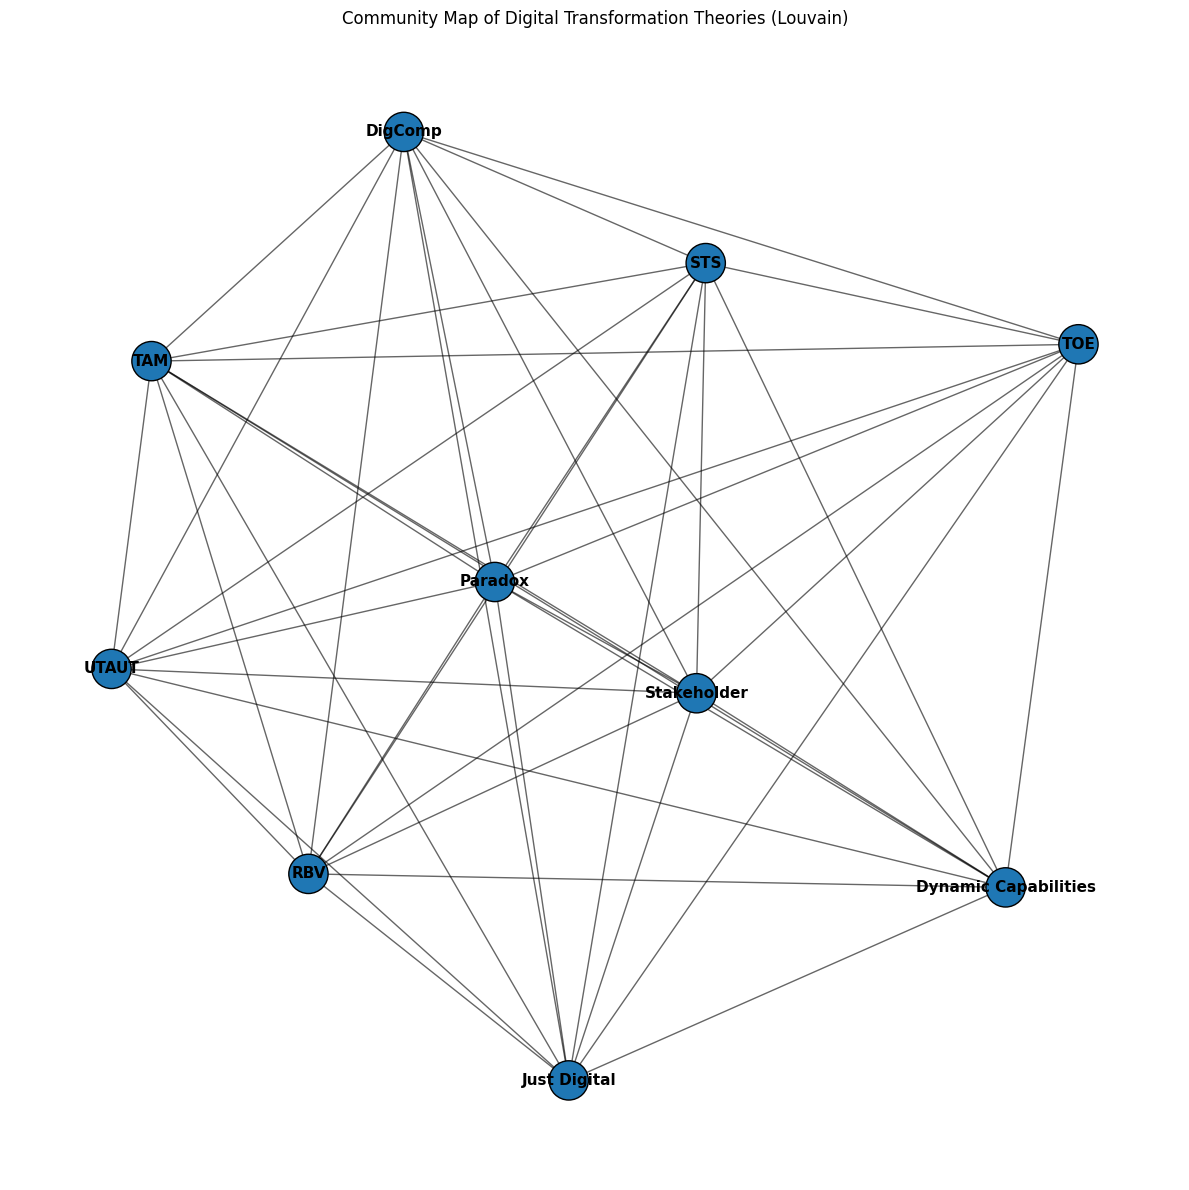

In [ ]:

!pip install -q python-louvain

# ایمپورت صحیح ماژول Louvain
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()
for (t1, t2), w in co_occurrence.items():
    G.add_edge(t1, t2, weight=w)

# اجرای Louvain
partition = community_louvain.best_partition(G, weight="weight")

# آماده‌سازی رنگ‌ها بر اساس اجتماع
communities = list(set(partition.values()))
color_map = [partition[n] for n in G.nodes()]

# layout پایدار
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(
    G, pos,
    node_color=color_map,
    cmap=plt.cm.tab10,
    node_size=800,
    edgecolors="black"
)

nx.draw_networkx_edges(
    G, pos,
    alpha=0.6
)

nx.draw_networkx_labels(
    G, pos,
    font_size=11,
    font_weight="bold"
)

plt.title("Community Map of Digital Transformation Theories (Louvain)")
plt.axis("off")
plt.tight_layout()

plt.savefig(
    os.path.join(BASE_OUT, "Figure_Community_Map_Louvain.png"),
    dpi=300
)

plt.show()

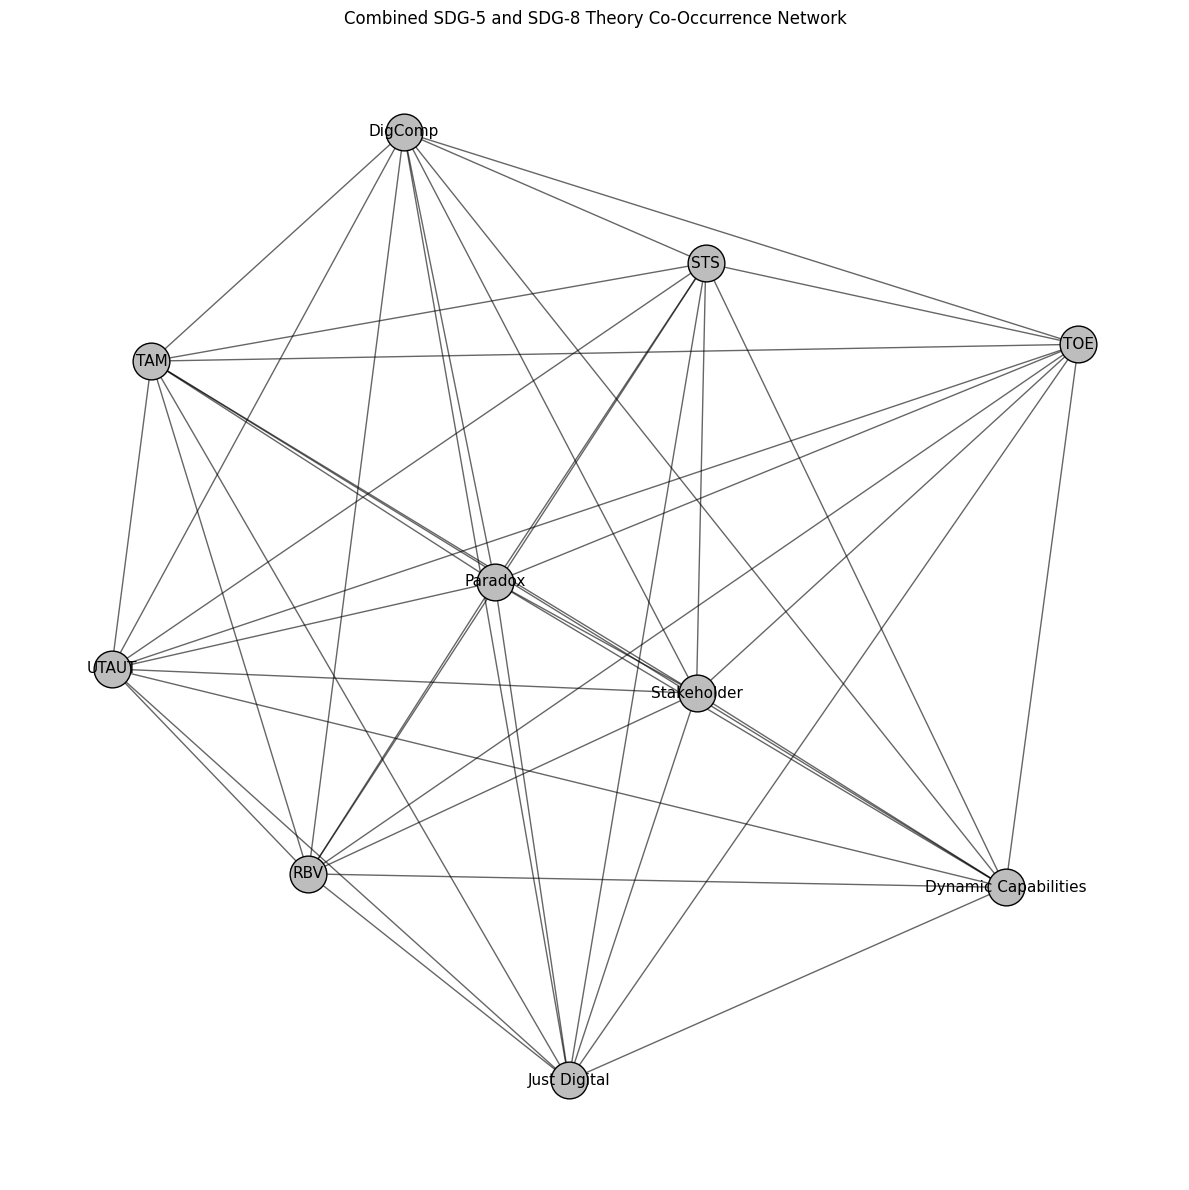

In [ ]:


plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(
    G, pos,
    node_size=700,
    node_color="#bdbdbd",
    edgecolors="black"
)

nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=11)

plt.title("Combined SDG-5 and SDG-8 Theory Co-Occurrence Network")
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_OUT, "Figure_SDG5_SDG8_Combined_Network.png"), dpi=300)
plt.show()

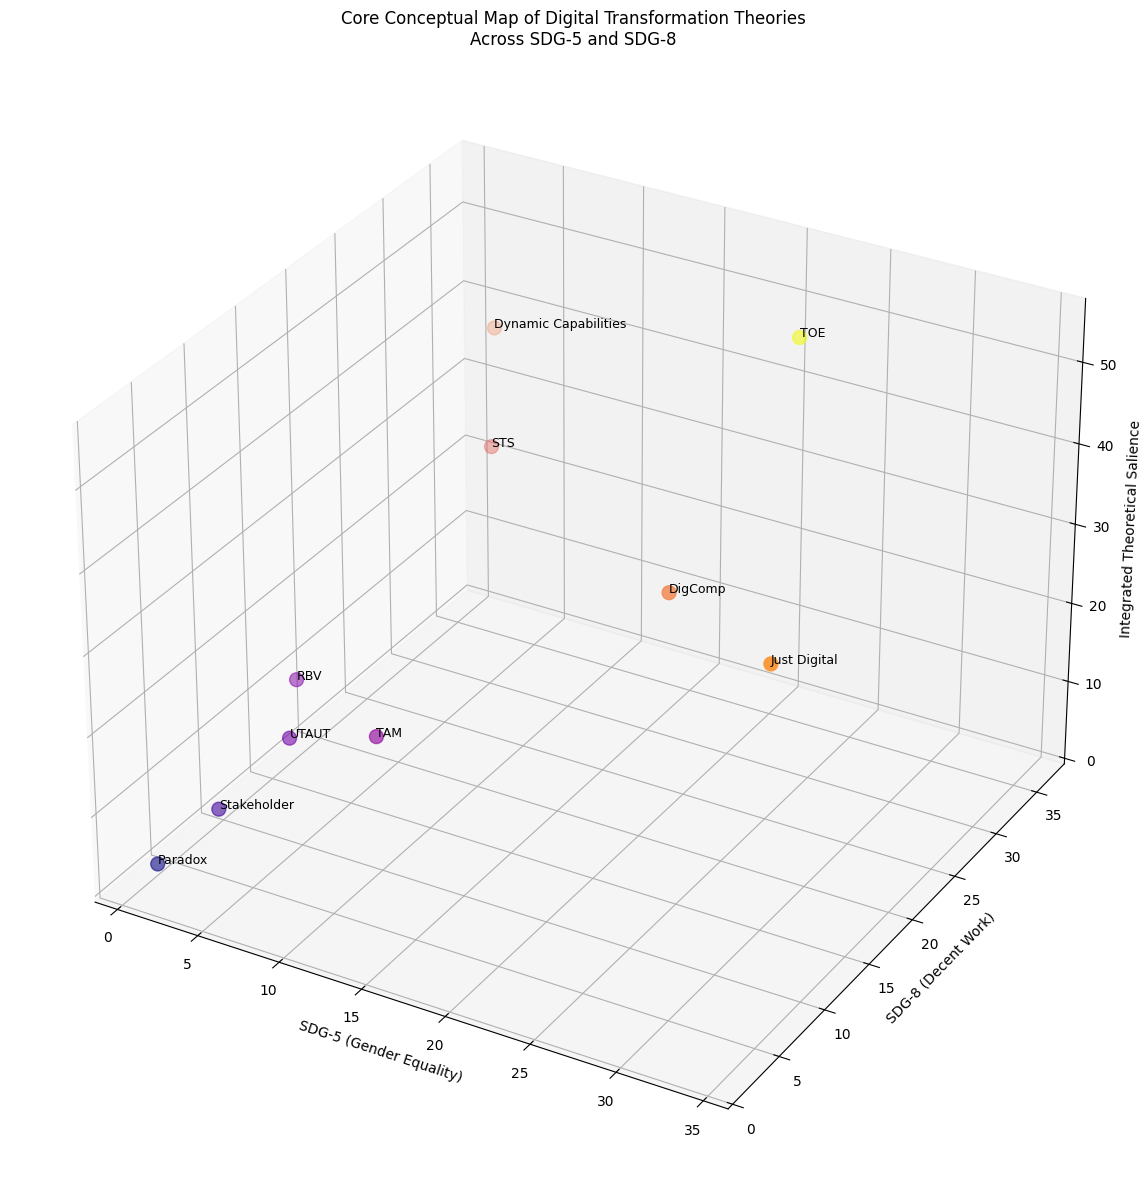

In [ ]:


from mpl_toolkits.mplot3d import Axes3D

strength_5 = final_df[final_df["SDG"]=="SDG5"]["Dominant_DT_Theory"].value_counts()
strength_8 = final_df[final_df["SDG"]=="SDG8"]["Dominant_DT_Theory"].value_counts()

nodes = list(set(strength_5.index) | set(strength_8.index))

x = np.array([strength_5.get(n,0) for n in nodes])
y = np.array([strength_8.get(n,0) for n in nodes])
z = x + y

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z, s=100, c=z, cmap="plasma")

for i,n in enumerate(nodes):
    ax.text(x[i], y[i], z[i], n, fontsize=9)

ax.set_xlabel("SDG-5 (Gender Equality)")
ax.set_ylabel("SDG-8 (Decent Work)")
ax.set_zlabel("Integrated Theoretical Salience")

ax.set_title(
    "Core Conceptual Map of Digital Transformation Theories\nAcross SDG-5 and SDG-8"
)

plt.tight_layout()
plt.savefig(os.path.join(BASE_OUT, "Figure_Core_Conceptual_Map_3D.png"), dpi=300)
plt.show()

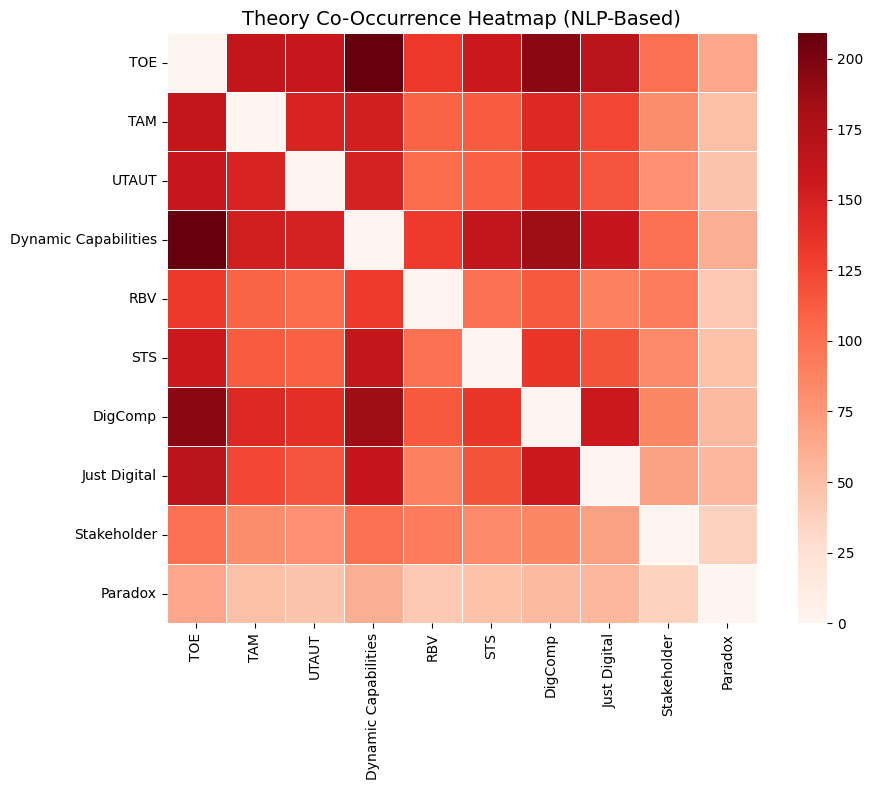

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


theory_cols = [c for c in final_df.columns if c.startswith("Score_")]
theories = [c.replace("Score_", "") for c in theory_cols]


co_matrix = pd.DataFrame(
    0, index=theories, columns=theories
)


THRESHOLD = 0.15

for _, row in final_df.iterrows():
    active = [
        t.replace("Score_", "")
        for t in theory_cols
        if row[t] >= THRESHOLD
    ]
    for t1, t2 in itertools.combinations(active, 2):
        co_matrix.loc[t1, t2] += 1
        co_matrix.loc[t2, t1] += 1


plt.figure(figsize=(10, 8))
sns.heatmap(
    co_matrix,
    cmap="Reds",
    linewidths=0.5,
    square=True
)

plt.title(
    "Theory Co-Occurrence Heatmap (NLP-Based)",
    fontsize=14
)

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Heatmap_Theory_CoOccurrence.png"),
    dpi=300
)
plt.show()

SDG 5–8 Intersection

In [ ]:


import pandas as pd
import os

final_df = pd.read_csv(
    os.path.join(BASE_OUT, "DT_Theory_by_SDG_from_Filename.csv")
)

final_df.shape, final_df.head()

((269, 13),
             File   SDG    Dominant_DT_Theory  Score_TOE  Score_TAM  \
 0  SDG8_003.docx  SDG8  Dynamic Capabilities   0.150772   0.095876   
 1  SDG8_005.docx  SDG8                   TOE   0.392667   0.256806   
 2  SDG8_008.docx  SDG8  Dynamic Capabilities   0.065701   0.093956   
 3  SDG8_009.docx  SDG8                   RBV   0.280677   0.257417   
 4  SDG8_010.docx  SDG8                   RBV   0.213892   0.160783   
 
    Score_UTAUT  Score_Dynamic Capabilities  Score_RBV  Score_STS  \
 0     0.066254                    0.214053   0.124091   0.174199   
 1     0.306468                    0.344349   0.221807   0.293295   
 2     0.062746                    0.159525   0.131517   0.087841   
 3     0.222686                    0.219277   0.309437   0.277103   
 4     0.134898                    0.199397   0.241720   0.151346   
 
    Score_DigComp  Score_Just Digital  Score_Stakeholder  Score_Paradox  
 0       0.198795            0.116218           0.036695       0.05848

In [ ]:


import os
from docx import Document
from sentence_transformers import util

ANCHOR_PATH = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/Files/"

ANCHOR_FILES = {
    "Anchor Paper 1 (SDG5–8)": "SDG58-1.docx",
    "Anchor Paper 2 (SDG5–8)": "SDG58-2.docx",
    "Anchor Paper 3 (SDG5–8)": "SDG58-3.docx"
}


for f in ANCHOR_FILES.values():
    assert os.path.exists(os.path.join(ANCHOR_PATH, f)), f"{f} پیدا نشد"

In [ ]:

DT_THEORIES = {
    "TOE": "Technology Organization Environment framework for digital transformation readiness and adoption",
    "TAM": "Technology Acceptance Model focusing on perceived usefulness and perceived ease of use",
    "UTAUT": "Unified Theory of Acceptance and Use of Technology explaining user adoption and usage behavior",
    "Dynamic Capabilities": "Dynamic capabilities theory focusing on sensing seizing and transforming under digital change",
    "RBV": "Resource Based View emphasizing competitive advantage through organizational resources",
    "STS": "Socio Technical Systems theory emphasizing joint optimization of social and technical systems",
    "DigComp": "Digital competence framework focusing on skills literacy and digital capability development",
    "Just Digital": "Just Digital framework focusing on fairness inclusion equity and digital justice",
    "Stakeholder": "Stakeholder theory emphasizing value creation for multiple stakeholders",
    "Paradox": "Paradox theory focusing on managing tensions contradictions and competing demands"
}

# استخراج نام و متن نظریه‌ها
theory_names = list(DT_THEORIES.keys())
theory_texts = list(DT_THEORIES.values())

# ساخت embedding نظریه‌ها
theory_embeddings = model.encode(
    theory_texts,
    normalize_embeddings=True
)

In [ ]:
# ===============================
# Anchor
# ===============================

def read_docx_text(path):
    try:
        doc = Document(path)
        return " ".join(p.text for p in doc.paragraphs if p.text)
    except Exception as e:
        print(f"خطا در خواندن {path}: {e}")
        return ""

anchor_texts = {}

for label, fname in ANCHOR_FILES.items():
    full_path = os.path.join(ANCHOR_PATH, fname)
    anchor_texts[label] = read_docx_text(full_path)

{ k: len(v) for k, v in anchor_texts.items() }

{'Anchor Paper 1 (SDG5–8)': 58380,
 'Anchor Paper 2 (SDG5–8)': 176733,
 'Anchor Paper 3 (SDG5–8)': 22136}

In [ ]:
# ===============================
# NLP
# ===============================

anchor_scores = {}

for label, text in anchor_texts.items():
    if len(text.strip()) < 500:
        print(f"متن {label} خیلی کوتاه است")
        continue

    emb = model.encode(text, normalize_embeddings=True)
    sims = util.cos_sim(emb, theory_embeddings).cpu().numpy()[0]

    anchor_scores[label] = dict(zip(theory_names, sims))

anchor_scores

{'Anchor Paper 1 (SDG5–8)': {'TOE': np.float32(0.46945515),
  'TAM': np.float32(0.17725179),
  'UTAUT': np.float32(0.19305743),
  'Dynamic Capabilities': np.float32(0.37476748),
  'RBV': np.float32(0.21762806),
  'STS': np.float32(0.29852936),
  'DigComp': np.float32(0.37419996),
  'Just Digital': np.float32(0.28137988),
  'Stakeholder': np.float32(0.15204051),
  'Paradox': np.float32(0.03763253)},
 'Anchor Paper 2 (SDG5–8)': {'TOE': np.float32(0.40558925),
  'TAM': np.float32(0.14390334),
  'UTAUT': np.float32(0.11715862),
  'Dynamic Capabilities': np.float32(0.35149598),
  'RBV': np.float32(0.1505066),
  'STS': np.float32(0.13831681),
  'DigComp': np.float32(0.46861202),
  'Just Digital': np.float32(0.3907628),
  'Stakeholder': np.float32(0.10978762),
  'Paradox': np.float32(0.11941721)},
 'Anchor Paper 3 (SDG5–8)': {'TOE': np.float32(0.5030514),
  'TAM': np.float32(0.25554392),
  'UTAUT': np.float32(0.2540263),
  'Dynamic Capabilities': np.float32(0.34730473),
  'RBV': np.float32(0.

In [ ]:
# ===============================
# ساخت جدول Anchor × Theory × Similarity
# ===============================

import pandas as pd

anchor_table = pd.DataFrame(anchor_scores).T
anchor_table = anchor_table[theory_names]

anchor_table
anchor_table.round(3)
anchor_table.to_csv(
    os.path.join(BASE_OUT, "Table_Anchor_Theory_Similarity.csv")
)

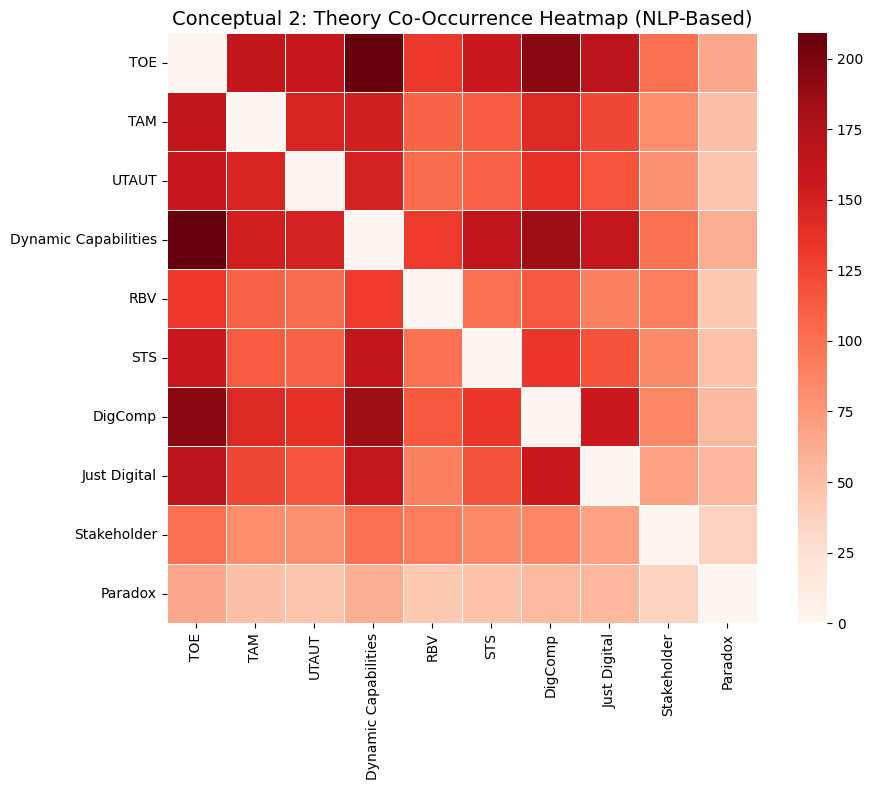

In [ ]:
# ===============================
# هیت‌مپ هم‌وقوعی نظریه‌ها (Conceptual 2 - اصلی)
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# استخراج ستون‌های نظریه
theory_cols = [c for c in final_df.columns if c.startswith("Score_")]
theories = [c.replace("Score_", "") for c in theory_cols]

# ساخت ماتریس هم‌وقوعی
co_matrix = pd.DataFrame(
    0, index=theories, columns=theories
)

# آستانه فعال‌بودن نظریه در مقاله
THRESHOLD = 0.15

for _, row in final_df.iterrows():
    active = [
        col.replace("Score_", "")
        for col in theory_cols
        if row[col] >= THRESHOLD
    ]
    for t1, t2 in itertools.combinations(active, 2):
        co_matrix.loc[t1, t2] += 1
        co_matrix.loc[t2, t1] += 1

# رسم هیت‌مپ
plt.figure(figsize=(10, 8))
sns.heatmap(
    co_matrix,
    cmap="Reds",
    linewidths=0.5,
    square=True
)

plt.title(
    "Conceptual 2: Theory Co-Occurrence Heatmap (NLP-Based)",
    fontsize=14
)

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Heatmap_Conceptual2_Theory_CoOccurrence.png"),
    dpi=300
)
plt.show()

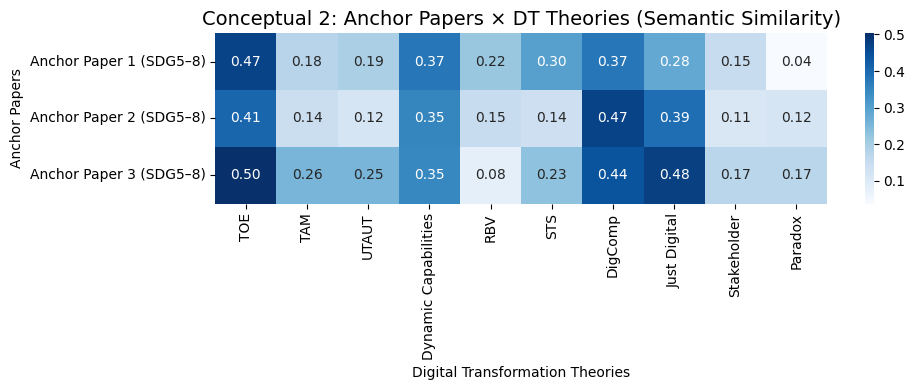

In [ ]:
# ===============================
# هیت‌مپ Anchor × Theory (اعتبارسنجی تقاطع)
# ===============================

anchor_table = pd.DataFrame(anchor_scores).T
anchor_table = anchor_table[theory_names]

plt.figure(figsize=(10, 4))
sns.heatmap(
    anchor_table,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)

plt.title(
    "Conceptual 2: Anchor Papers × DT Theories (Semantic Similarity)",
    fontsize=14
)

plt.ylabel("Anchor Papers")
plt.xlabel("Digital Transformation Theories")

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Heatmap_Conceptual2_Anchor_Theory.png"),
    dpi=300
)
plt.show()

In [ ]:
# ===============================
# محاسبه موقعیت نظریه‌ها روی دو محور SDG5 و SDG8
# ===============================

import pandas as pd
import numpy as np

# استخراج ستون‌های امتیاز نظریه‌ها
theory_cols = [c for c in final_df.columns if c.startswith("Score_")]
theories = [c.replace("Score_", "") for c in theory_cols]

# میانگین امتیاز نظریه‌ها برای SDG5
sdg5_means = (
    final_df[final_df["SDG"] == "SDG5"][theory_cols]
    .mean()
    .rename(lambda x: x.replace("Score_", ""))
)

# میانگین امتیاز نظریه‌ها برای SDG8
sdg8_means = (
    final_df[final_df["SDG"] == "SDG8"][theory_cols]
    .mean()
    .rename(lambda x: x.replace("Score_", ""))
)

# ساخت جدول موقعیت نظریه‌ها
dual_axis_df = pd.DataFrame({
    "Theory": theories,
    "SDG5_Orientation": sdg5_means.values,
    "SDG8_Orientation": sdg8_means.values
})

dual_axis_df
#dual_axis_df.to_csv(
#    os.path.join(BASE_OUT, "Theory_SDG5_SDG8_Orientation.csv")

Theory  SDG5_Orientation  SDG8_Orientation
0                   TOE          0.311408          0.254818
1                   TAM          0.216657          0.184441
2                 UTAUT          0.209283          0.177207
3  Dynamic Capabilities          0.229952          0.251797
4                   RBV          0.129145          0.181717
5                   STS          0.164544          0.202105
6               DigComp          0.286343          0.217838
7          Just Digital          0.270747          0.165746
8           Stakeholder          0.121586          0.129285
9               Paradox          0.121386          0.097993

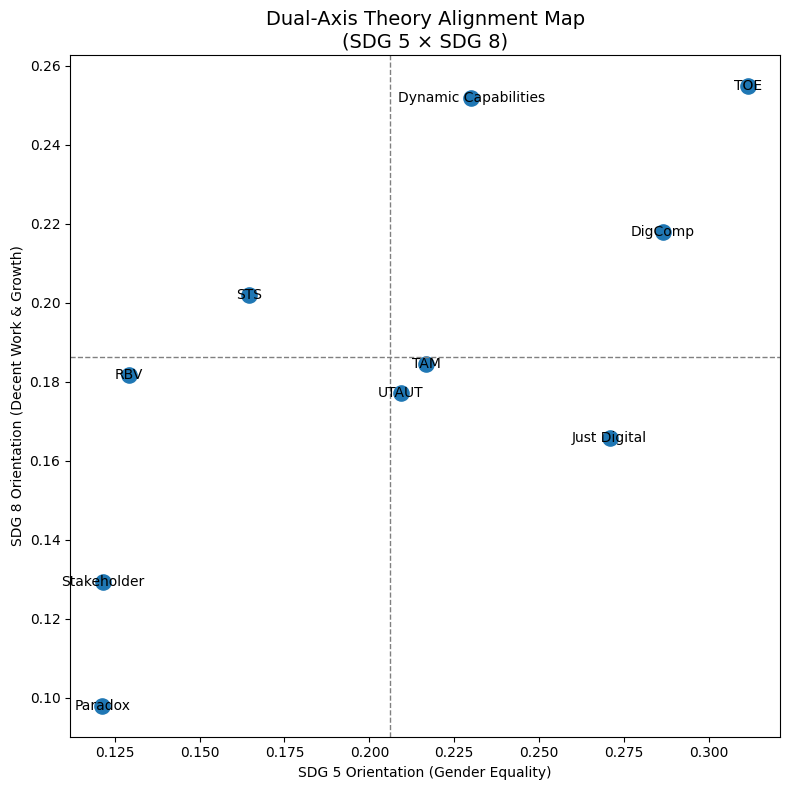

In [ ]:
# ===============================
# رسم نقشه دو محوره نظریه‌ها (SDG5 × SDG8)
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

plt.scatter(
    dual_axis_df["SDG5_Orientation"],
    dual_axis_df["SDG8_Orientation"],
    s=120
)

for _, row in dual_axis_df.iterrows():
    plt.text(
        row["SDG5_Orientation"],
        row["SDG8_Orientation"],
        row["Theory"],
        fontsize=10,
        ha="center",
        va="center"
    )

plt.axvline(
    dual_axis_df["SDG5_Orientation"].mean(),
    linestyle="--",
    color="gray",
    linewidth=1
)

plt.axhline(
    dual_axis_df["SDG8_Orientation"].mean(),
    linestyle="--",
    color="gray",
    linewidth=1
)

plt.xlabel("SDG 5 Orientation (Gender Equality)")
plt.ylabel("SDG 8 Orientation (Decent Work & Growth)")

plt.title(
    "Dual-Axis Theory Alignment Map\n(SDG 5 × SDG 8)",
    fontsize=14
)

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Figure_Dual_Axis_Theory_Map.png"),
    dpi=300
)
plt.show()

In [ ]:


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

OUTCOME_THEORY_MAP = {
    "Female Labor-Force Participation": [
        "TOE", "Dynamic Capabilities", "DigComp"
    ],
    "Gender Pay Gaps": [
        "Just Digital", "DigComp", "Stakeholder"
    ],
    "Precarity & Informality": [
        "STS", "RBV", "Paradox"
    ],
    "Access to Decent, Future-Oriented Work": [
        "TOE", "Dynamic Capabilities", "DigComp", "STS"
    ]
}

theory_cols = [c for c in final_df.columns if c.startswith("Score_")]

theory_strength = (
    final_df[theory_cols]
    .mean()
    .rename(lambda x: x.replace("Score_", ""))
)


outcome_strength = {}

for outcome, theories in OUTCOME_THEORY_MAP.items():
    outcome_strength[outcome] = theory_strength[theories].mean()

outcome_strength

{'Female Labor-Force Participation': np.float64(0.2563079680838202),
 'Gender Pay Gaps': np.float64(0.1947615255073257),
 'Precarity & Informality': np.float64(0.1510231014708529),
 'Access to Decent, Future-Oriented Work': np.float64(0.23871269304835505)}

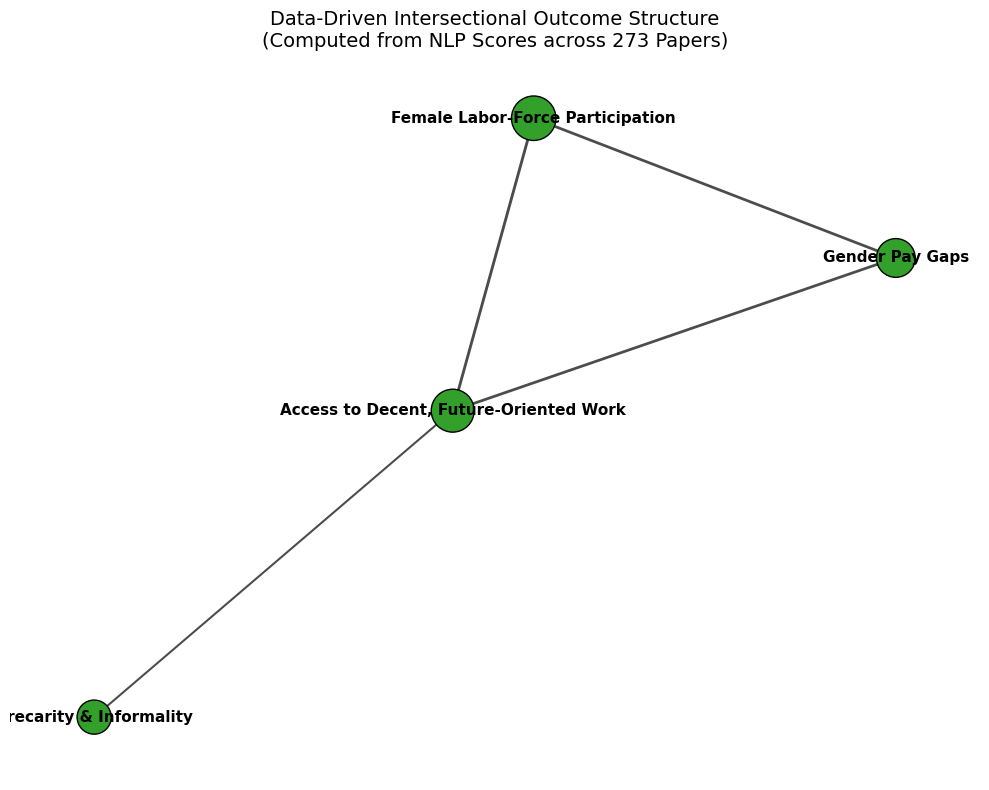

In [ ]:


G = nx.Graph()


for outcome, strength in outcome_strength.items():
    G.add_node(outcome, size=strength)

for o1, t1 in OUTCOME_THEORY_MAP.items():
    for o2, t2 in OUTCOME_THEORY_MAP.items():
        if o1 != o2:
            shared = set(t1) & set(t2)
            if shared:
                weight = theory_strength[list(shared)].mean()
                G.add_edge(o1, o2, weight=weight)

# layout
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(
    G, pos,
    node_size=[G.nodes[n]["size"] * 4000 for n in G.nodes()],
    node_color="#33a02c",
    edgecolors="black"
)

nx.draw_networkx_edges(
    G, pos,
    width=[G[u][v]["weight"] * 8 for u, v in G.edges()],
    alpha=0.7
)

nx.draw_networkx_labels(
    G, pos,
    font_size=11,
    font_weight="bold"
)

plt.title(
    "Data-Driven Intersectional Outcome Structure\n(Computed from NLP Scores across 273 Papers)",
    fontsize=14
)

plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# جدول نهایی Conceptual 3: Outcome × Strength
# ===============================

import pandas as pd

conceptual3_table = pd.DataFrame.from_dict(
    outcome_strength,
    orient="index",
    columns=["Aggregated Outcome Strength"]
)

conceptual3_table = conceptual3_table.sort_values(
    "Aggregated Outcome Strength",
    ascending=False
)

conceptual3_table
conceptual3_table.to_csv(
    os.path.join(BASE_OUT, "Table_Conceptual3_Outcome_Strength.csv")
)

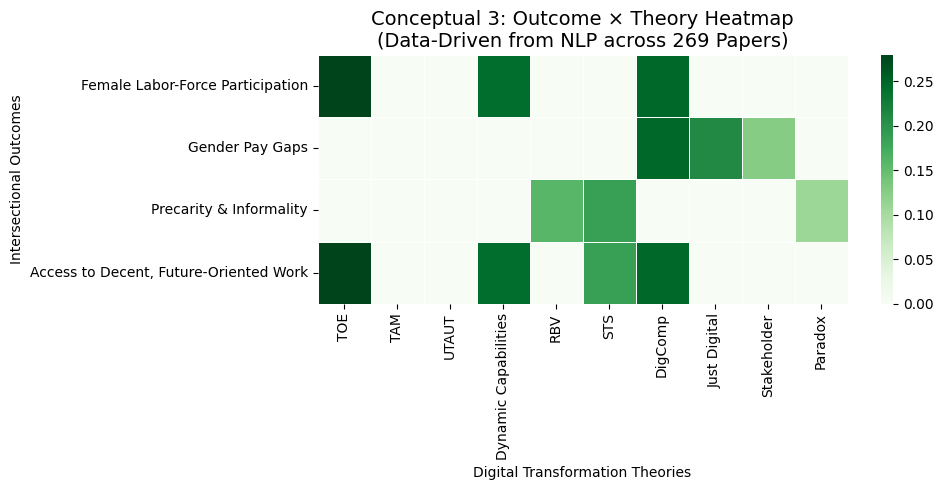

In [ ]:
# ===============================
# هیت‌مپ Outcome × Theory (Conceptual 3)
# ===============================

import seaborn as sns
import matplotlib.pyplot as plt

# ساخت ماتریس outcome × theory
outcome_theory_matrix = pd.DataFrame(
    index=OUTCOME_THEORY_MAP.keys(),
    columns=theory_names
)

for outcome, theories in OUTCOME_THEORY_MAP.items():
    for t in theory_names:
        if t in theories:
            outcome_theory_matrix.loc[outcome, t] = theory_strength[t]
        else:
            outcome_theory_matrix.loc[outcome, t] = 0

plt.figure(figsize=(10, 5))
sns.heatmap(
    outcome_theory_matrix.astype(float),
    cmap="Greens",
    linewidths=0.5
)

plt.title(
    "Conceptual 3: Outcome × Theory Heatmap\n(Data-Driven from NLP across 269 Papers)",
    fontsize=14
)

plt.xlabel("Digital Transformation Theories")
plt.ylabel("Intersectional Outcomes")

plt.tight_layout()
plt.savefig(
    os.path.join(BASE_OUT, "Heatmap_Conceptual3_Outcome_Theory.png"),
    dpi=300
)
plt.show()

In [ ]:


import pandas as pd
import os


BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/Files/"
BASE_OUT  = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"

DATA_FILE = os.path.join(BASE_OUT, "DT_Theory_by_SDG_from_Filename.csv")

assert os.path.exists(DATA_FILE), f"File not found: {DATA_FILE}"


final_df = pd.read_csv(DATA_FILE)

print("Dataset loaded")
print("Total documents:", final_df.shape[0])

# ------------------------------------------------------------
# SANITY CHECKS
# ------------------------------------------------------------
assert "SDG" in final_df.columns, "SDG column missing"
assert any(c.startswith("Score_") for c in final_df.columns), "Score_* columns missing"

# ------------------------------------------------------------
#  SPLIT INTO SDG5 AND SDG8 CORPORA
# ------------------------------------------------------------
sdg5_docs = final_df[final_df["SDG"] == "SDG5"].copy()
sdg8_docs = final_df[final_df["SDG"] == "SDG8"].copy()

print("SDG5 documents:", sdg5_docs.shape[0])
print("SDG8 documents:", sdg8_docs.shape[0])

# ------------------------------------------------------------
# DEFINE TECHNOLOGY-RELATED THEORIES
# ------------------------------------------------------------
TECH_THEORIES = [
    "TOE",
    "DigComp",
    "Dynamic Capabilities",
    "STS"
]

tech_score_cols = [f"Score_{t}" for t in TECH_THEORIES]

for col in tech_score_cols:
    assert col in final_df.columns, f"Missing column: {col}"

# ------------------------------------------------------------
# COMPUTE TECHNOLOGY INTENSITY
# ------------------------------------------------------------
# SDG5
sdg5_docs["Technology_Mean"] = sdg5_docs[tech_score_cols].mean(axis=1)
sdg5_docs["Technology_Peak"] = sdg5_docs[tech_score_cols].max(axis=1)

# SDG8
sdg8_docs["Technology_Mean"] = sdg8_docs[tech_score_cols].mean(axis=1)
sdg8_docs["Technology_Peak"] = sdg8_docs[tech_score_cols].max(axis=1)

# ------------------------------------------------------------
# DESCRIPTIVE STATISTICS (SEPARATE)
# ------------------------------------------------------------
sdg5_stats = sdg5_docs[["Technology_Mean", "Technology_Peak"]].describe()
sdg8_stats = sdg8_docs[["Technology_Mean", "Technology_Peak"]].describe()

print("\nSDG5 Technology Intensity Statistics")
display(sdg5_stats)

print("\nSDG8 Technology Intensity Statistics")
display(sdg8_stats)

# ------------------------------------------------------------
# COMBINED COMPARISON TABLE (PAPER-READY)
# ------------------------------------------------------------
combined_stats = pd.concat(
    {
        "SDG 5": sdg5_stats,
        "SDG 8": sdg8_stats
    },
    axis=1
)

print("\nCombined SDG5 vs SDG8 Technology Intensity Statistics")
display(combined_stats)


OUTPUT_FILE = os.path.join(
    BASE_OUT,
    "Table_Descriptive_Technology_Intensity_SDG5_SDG8.csv"
)

combined_stats.to_csv(OUTPUT_FILE)

print(f"\nSaved output to: {OUTPUT_FILE}")

Dataset loaded
Total documents: 269
SDG5 documents: 117
SDG8 documents: 152

SDG5 Technology Intensity Statistics


Technology_Mean  Technology_Peak
count       115.000000       115.000000
mean          0.248062         0.342482
std           0.085348         0.120432
min           0.058435         0.084805
25%           0.191015         0.257031
50%           0.246607         0.334678
75%           0.312539         0.428925
max           0.435259         0.613277


SDG8 Technology Intensity Statistics


Technology_Mean  Technology_Peak
count       152.000000       152.000000
mean          0.231639         0.304088
std           0.080284         0.102144
min          -0.007114         0.060130
25%           0.168791         0.221486
50%           0.238725         0.292520
75%           0.284695         0.371580
max           0.441338         0.696092


Combined SDG5 vs SDG8 Technology Intensity Statistics


SDG 5                           SDG 8                
      Technology_Mean Technology_Peak Technology_Mean Technology_Peak
count      115.000000      115.000000      152.000000      152.000000
mean         0.248062        0.342482        0.231639        0.304088
std          0.085348        0.120432        0.080284        0.102144
min          0.058435        0.084805       -0.007114        0.060130
25%          0.191015        0.257031        0.168791        0.221486
50%          0.246607        0.334678        0.238725        0.292520
75%          0.312539        0.428925        0.284695        0.371580
max          0.435259        0.613277        0.441338        0.696092


Saved output to: /content/drive/MyDrive/Colab Notebooks/DTOSDG58/Table_Descriptive_Technology_Intensity_SDG5_SDG8.csv


SDG8 documents: 152


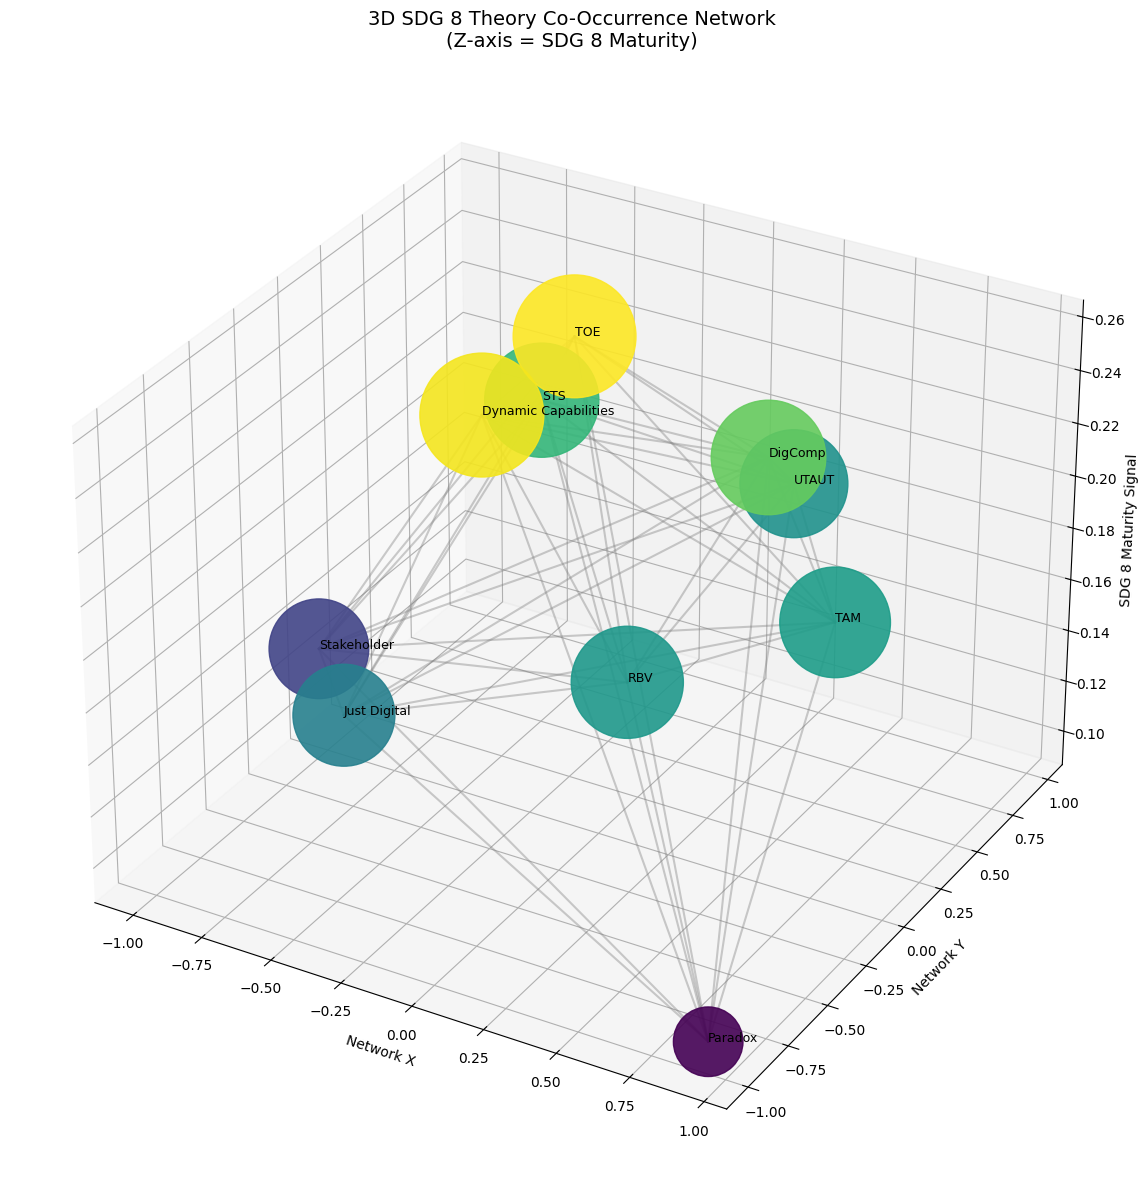

In [ ]:


import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
df = pd.read_csv(f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv")

# فقط SDG 8
sdg8 = df[df["SDG"] == "SDG8"].copy()
print("SDG8 documents:", sdg8.shape[0])

# ------------------------------------------------------------
# Theories
# ------------------------------------------------------------
theory_cols = [c for c in sdg8.columns if c.startswith("Score_")]
theories = [c.replace("Score_", "") for c in theory_cols]


CO_THRESHOLD = 0.15
co_occurrence = {}

for _, row in sdg8.iterrows():
    active = [
        col.replace("Score_", "")
        for col in theory_cols
        if row[col] >= CO_THRESHOLD
    ]
    for t1, t2 in itertools.combinations(active, 2):
        key = tuple(sorted([t1, t2]))
        co_occurrence[key] = co_occurrence.get(key, 0) + 1

# ------------------------------------------------------------
#Graph
# ------------------------------------------------------------
G = nx.Graph()
for (t1, t2), w in co_occurrence.items():
    G.add_edge(t1, t2, weight=w)


SDG8_THEORIES = ["TOE", "Dynamic Capabilities", "RBV"]

sdg8_maturity = {}
for t in theories:
    col = f"Score_{t}"
    if col in sdg8.columns:
        sdg8_maturity[t] = sdg8[col].mean()
    else:
        sdg8_maturity[t] = 0.0


strength = dict(G.degree(weight="weight"))


pos_2d = nx.spring_layout(G, seed=42)
xs = []
ys = []
zs = []
sizes = []
labels = []

for node in G.nodes():
    x, y = pos_2d[node]
    z = sdg8_maturity.get(node, 0)
    xs.append(x)
    ys.append(y)
    zs.append(z)
    sizes.append(300 + strength.get(node, 0) * 10)
    labels.append(node)


fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs, ys, zs, s=sizes, c=zs, cmap="viridis", alpha=0.9)

# یال‌ها
for u, v, d in G.edges(data=True):
    x = [pos_2d[u][0], pos_2d[v][0]]
    y = [pos_2d[u][1], pos_2d[v][1]]
    z = [sdg8_maturity[u], sdg8_maturity[v]]
    ax.plot(x, y, z, color="gray", alpha=0.4)

# برچسب‌ها
for i, label in enumerate(labels):
    ax.text(xs[i], ys[i], zs[i], label, fontsize=9)

ax.set_title(
    "3D SDG 8 Theory Co-Occurrence Network\n(Z-axis = SDG 8 Maturity)",
    fontsize=14
)
ax.set_xlabel("Network X")
ax.set_ylabel("Network Y")
ax.set_zlabel("SDG 8 Maturity Signal")

plt.tight_layout()
plt.savefig(
    f"{BASE_OUT}/Figure_SDG8_Theory_Network_3D.png",
    dpi=300
)
plt.show()

In [ ]:
import pandas as pd

BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
df = pd.read_csv(f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv")

df.head(), df.columns

(            File   SDG    Dominant_DT_Theory  Score_TOE  Score_TAM  \
 0  SDG8_003.docx  SDG8  Dynamic Capabilities   0.150772   0.095876   
 1  SDG8_005.docx  SDG8                   TOE   0.392667   0.256806   
 2  SDG8_008.docx  SDG8  Dynamic Capabilities   0.065701   0.093956   
 3  SDG8_009.docx  SDG8                   RBV   0.280677   0.257417   
 4  SDG8_010.docx  SDG8                   RBV   0.213892   0.160783   
 
    Score_UTAUT  Score_Dynamic Capabilities  Score_RBV  Score_STS  \
 0     0.066254                    0.214053   0.124091   0.174199   
 1     0.306468                    0.344349   0.221807   0.293295   
 2     0.062746                    0.159525   0.131517   0.087841   
 3     0.222686                    0.219277   0.309437   0.277103   
 4     0.134898                    0.199397   0.241720   0.151346   
 
    Score_DigComp  Score_Just Digital  Score_Stakeholder  Score_Paradox  
 0       0.198795            0.116218           0.036695       0.058481  
 1      

In [ ]:


CONSTRAINT_THEORIES = ["Just Digital", "Stakeholder", "Paradox"]
score_cols = [f"Score_{t}" for t in CONSTRAINT_THEORIES]

# sanity check
for c in score_cols:
    assert c in sdg5.columns, f"Missing column: {c}"

sdg5["SDG5_Constraint_v2"] = 1 - sdg5[score_cols].mean(axis=1)

sdg5["SDG5_Constraint_v2"].describe()

count    115.000000
mean       0.828760
std        0.056593
min        0.687573
25%        0.792623
50%        0.828817
75%        0.862080
max        1.012793
Name: SDG5_Constraint_v2, dtype: float64

SDG5 documents: 117


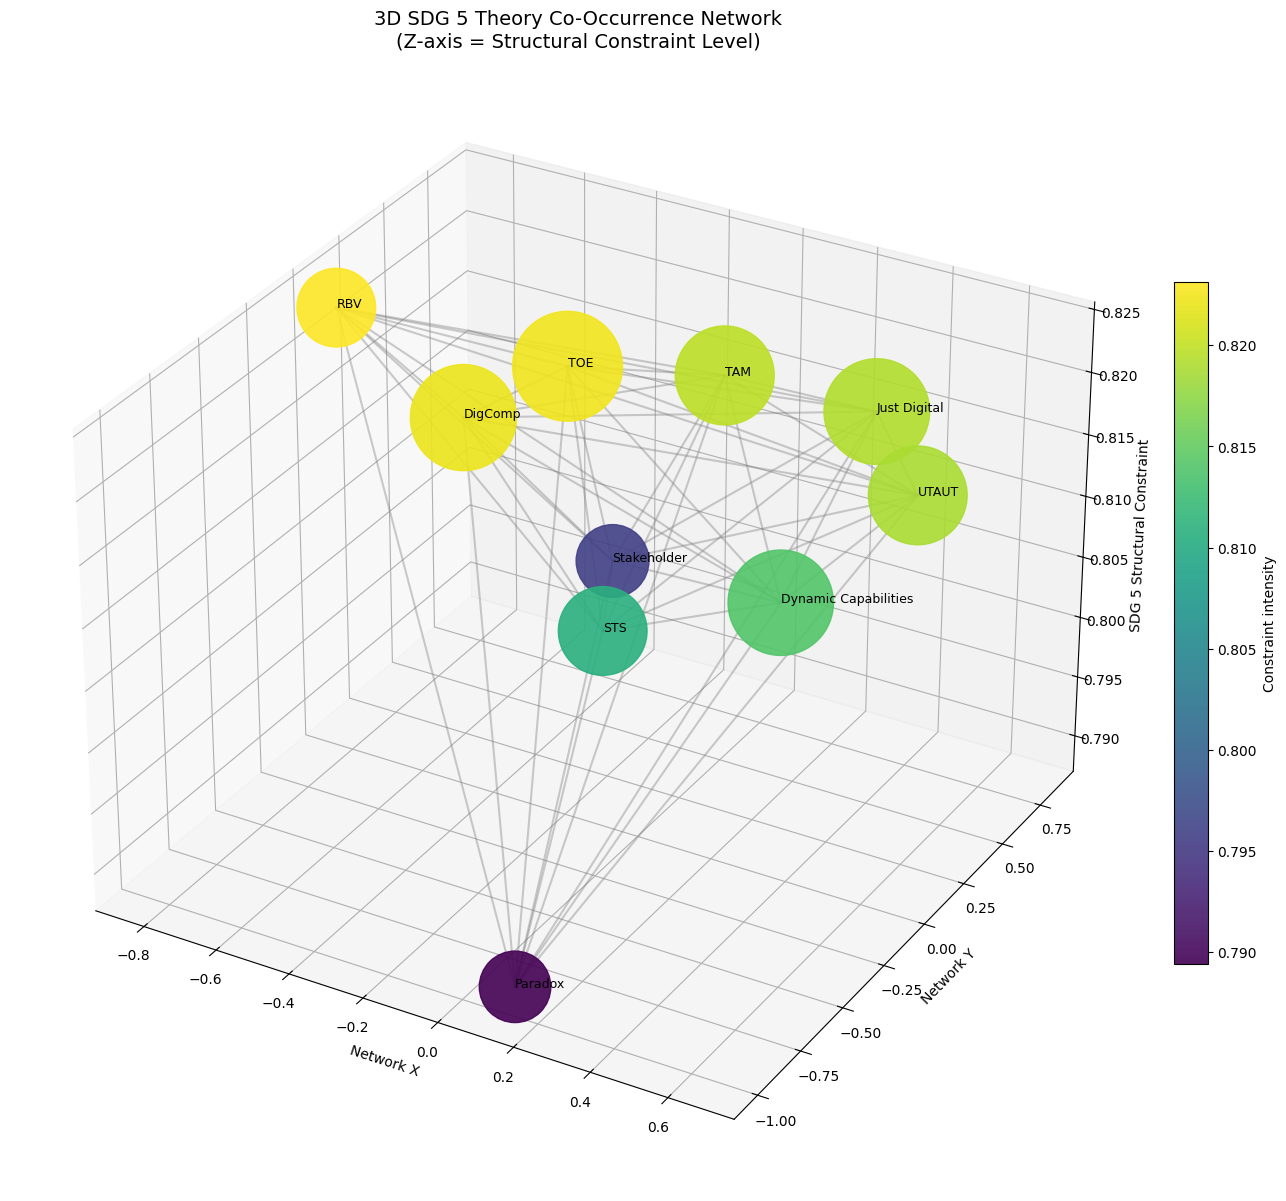

In [ ]:


import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
df = pd.read_csv(f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv")


sdg5 = df[df["SDG"] == "SDG5"].copy()
print("SDG5 documents:", sdg5.shape[0])

# -------------------------
# Theory columns
# -------------------------
theory_cols = [c for c in sdg5.columns if c.startswith("Score_")]
theories = [c.replace("Score_", "") for c in theory_cols]

# -------------------------
# Construct SDG5_Constraint_v2 (DATA-DRIVEN)
# تعریف: 1 − میانگین شباهت به نظریه‌های قیدمحور
# -------------------------
CONSTRAINT_THEORIES = ["Just Digital", "Stakeholder", "Paradox"]
constraint_score_cols = [f"Score_{t}" for t in CONSTRAINT_THEORIES]

for c in constraint_score_cols:
    assert c in sdg5.columns, f"Missing column: {c}"

sdg5["SDG5_Constraint_v2"] = 1 - sdg5[constraint_score_cols].mean(axis=1)

# -------------------------
# Build co-occurrence (thresholded)
# -------------------------
CO_THRESHOLD = 0.15
co_occ = {}

for _, row in sdg5.iterrows():
    active = [c.replace("Score_", "") for c in theory_cols if row[c] >= CO_THRESHOLD]
    for t1, t2 in itertools.combinations(active, 2):
        key = tuple(sorted([t1, t2]))
        co_occ[key] = co_occ.get(key, 0) + 1

G = nx.Graph()
for (t1, t2), w in co_occ.items():
    G.add_edge(t1, t2, weight=w)

# -------------------------
# Z-axis: mean SDG5 constraint per theory
# -------------------------
z_constraint = {}
for t in theories:
    col = f"Score_{t}"
    mask = sdg5[col] >= CO_THRESHOLD
    if mask.sum() > 0:
        z_constraint[t] = sdg5.loc[mask, "SDG5_Constraint_v2"].mean()
    else:
        z_constraint[t] = sdg5["SDG5_Constraint_v2"].mean()

# -------------------------
# Node size = weighted degree (strength)
# -------------------------
strength = dict(G.degree(weight="weight"))

# -------------------------
# 2D layout + 3D plot
# -------------------------
pos2d = nx.spring_layout(G, seed=42)

xs, ys, zs, sizes, labels = [], [], [], [], []
for n in G.nodes():
    x, y = pos2d[n]
    xs.append(x); ys.append(y)
    zs.append(z_constraint.get(n, 0.0))
    sizes.append(300 + 10 * strength.get(n, 0))
    labels.append(n)

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(xs, ys, zs, s=sizes, c=zs, cmap="viridis", alpha=0.9)

# edges
for u, v, d in G.edges(data=True):
    ax.plot(
        [pos2d[u][0], pos2d[v][0]],
        [pos2d[u][1], pos2d[v][1]],
        [z_constraint[u], z_constraint[v]],
        color="gray", alpha=0.4
    )

# labels
for i, lab in enumerate(labels):
    ax.text(xs[i], ys[i], zs[i], lab, fontsize=9)

ax.set_title(
    "3D SDG 5 Theory Co-Occurrence Network\n(Z-axis = Structural Constraint Level)",
    fontsize=14
)
ax.set_xlabel("Network X")
ax.set_ylabel("Network Y")
ax.set_zlabel("SDG 5 Structural Constraint")

plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02, label="Constraint intensity")
plt.tight_layout()
plt.savefig(f"{BASE_OUT}/Figure_SDG5_Theory_Network_3D.png", dpi=300)
plt.show()

SDG8 documents: 152


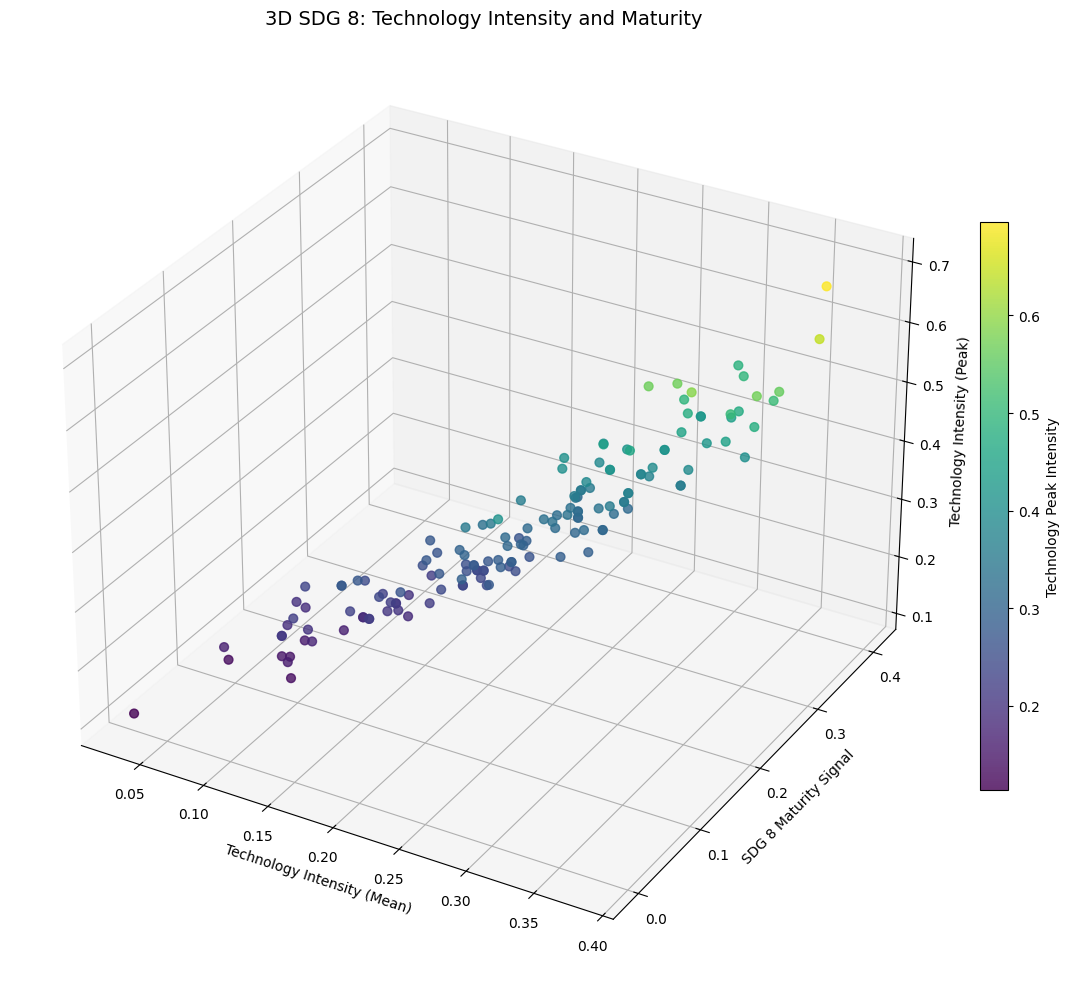

In [ ]:
# ============================================================
# 3D SDG 8: Technology Intensity vs Maturity (Scatter)
# Z-axis = Technology Peak
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

=
BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
df = pd.read_csv(f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv")

# SDG8 only
sdg8 = df[df["SDG"] == "SDG8"].copy()
print("SDG8 documents:", sdg8.shape[0])

# -------------------------
# Define technology theories
# -------------------------
TECH_THEORIES = ["TOE", "Dynamic Capabilities", "RBV", "DigComp", "STS", "TAM", "UTAUT"]

tech_score_cols = [f"Score_{t}" for t in TECH_THEORIES]
for c in tech_score_cols:
    assert c in sdg8.columns, f"Missing column: {c}"


sdg8["Technology_Mean"] = sdg8[tech_score_cols].mean(axis=1)
sdg8["Technology_Peak"] = sdg8[tech_score_cols].max(axis=1)


SDG8_CORE = ["TOE", "Dynamic Capabilities", "RBV"]
sdg8_core_cols = [f"Score_{t}" for t in SDG8_CORE]

sdg8["SDG8_Maturity"] = sdg8[sdg8_core_cols].mean(axis=1)

# -------------------------
# Prepare 3D scatter data
# -------------------------
x = sdg8["Technology_Mean"].values
y = sdg8["SDG8_Maturity"].values
z = sdg8["Technology_Peak"].values

# -------------------------
# Plot 3D scatter
# -------------------------
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    x, y, z,
    c=z, cmap="viridis",
    s=40, alpha=0.8
)

ax.set_xlabel("Technology Intensity (Mean)")
ax.set_ylabel("SDG 8 Maturity Signal")
ax.set_zlabel("Technology Intensity (Peak)")

ax.set_title(
    "3D SDG 8: Technology Intensity and Maturity",
    fontsize=14
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("Technology Peak Intensity")

plt.tight_layout()
plt.savefig(
    f"{BASE_OUT}/Figure_SDG8_Technology_Maturity_3D.png",
    dpi=300
)
plt.show()

SDG5 documents: 117


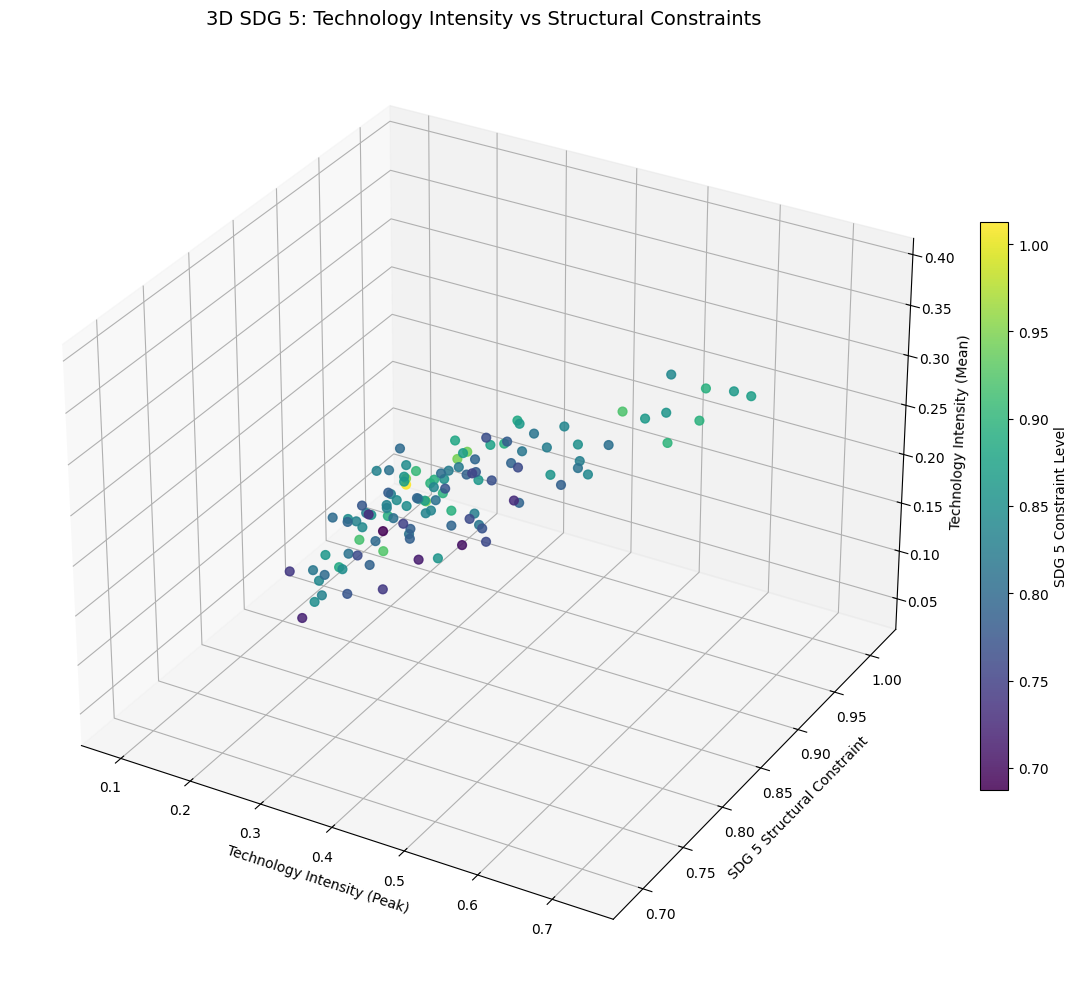

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
df = pd.read_csv(f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv")

# SDG5 only (بدون assert روی تعداد)
sdg5 = df[df["SDG"] == "SDG5"].copy()
print("SDG5 documents:", sdg5.shape[0])

# -------------------------
# Define technology theories
# -------------------------
TECH_THEORIES = ["TOE", "Dynamic Capabilities", "RBV", "DigComp", "STS", "TAM", "UTAUT"]
tech_cols = [f"Score_{t}" for t in TECH_THEORIES]
for c in tech_cols:
    assert c in sdg5.columns, f"Missing column: {c}"

# -------------------------
# Compute Technology Mean & Peak
# -------------------------
sdg5["Technology_Mean"] = sdg5[tech_cols].mean(axis=1)
sdg5["Technology_Peak"] = sdg5[tech_cols].max(axis=1)

# -------------------------
# Construct SDG5_Constraint_v2 if missing
# Definition: 1 − mean(similarity to governance/normative theories)
# -------------------------
CONSTRAINT_THEORIES = ["Just Digital", "Stakeholder", "Paradox"]
cons_cols = [f"Score_{t}" for t in CONSTRAINT_THEORIES]
for c in cons_cols:
    assert c in sdg5.columns, f"Missing column: {c}"

if "SDG5_Constraint_v2" not in sdg5.columns:
    sdg5["SDG5_Constraint_v2"] = 1 - sdg5[cons_cols].mean(axis=1)

# -------------------------
# Prepare 3D data
# -------------------------
x = sdg5["Technology_Peak"].values
y = sdg5["SDG5_Constraint_v2"].values
z = sdg5["Technology_Mean"].values

# -------------------------
# Plot 3D scatter
# -------------------------
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    x, y, z,
    c=y, cmap="viridis",
    s=40, alpha=0.85
)

ax.set_xlabel("Technology Intensity (Peak)")
ax.set_ylabel("SDG 5 Structural Constraint")
ax.set_zlabel("Technology Intensity (Mean)")
ax.set_title(
    "3D SDG 5: Technology Intensity vs Structural Constraints",
    fontsize=14
)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("SDG 5 Constraint Level")

plt.tight_layout()
plt.savefig(
    f"{BASE_OUT}/Figure_SDG5_Technology_Constraints_3D.png",
    dpi=300
)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# Load base data
# -----------------------------
BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
final_df = pd.read_csv(f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv")

# -----------------------------
# Define theory groups
# -----------------------------
TECH_THEORIES = ["TOE", "Dynamic Capabilities", "DigComp", "STS"]
CONSTRAINT_THEORIES = ["Just Digital", "Stakeholder", "Paradox"]
SDG8_THEORIES = ["TOE", "Dynamic Capabilities", "RBV"]

# -----------------------------
# Build Technology_Peak
# -----------------------------
final_df["Technology_Peak"] = final_df[
    [f"Score_{t}" for t in TECH_THEORIES]
].max(axis=1)

# -----------------------------
# Build SDG5_Constraint_v2
# -----------------------------
final_df["SDG5_Constraint_v2"] = final_df[
    [f"Score_{t}" for t in CONSTRAINT_THEORIES]
].mean(axis=1)

# -----------------------------
# Build SDG8_Signal
# -----------------------------
final_df["SDG8_Signal"] = final_df[
    [f"Score_{t}" for t in SDG8_THEORIES]
].mean(axis=1)

# -----------------------------
# Sanity check
# -----------------------------
final_df[[
    "SDG",
    "Technology_Peak",
    "SDG5_Constraint_v2",
    "SDG8_Signal"
]].describe()

Technology_Peak  SDG5_Constraint_v2  SDG8_Signal
count       267.000000          267.000000   267.000000
mean          0.320625            0.148337     0.226885
std           0.111810            0.066221     0.082075
min           0.060130           -0.025729    -0.008715
25%           0.233246            0.108071     0.163165
50%           0.309307            0.153673     0.226627
75%           0.394957            0.193948     0.280153
max           0.696092            0.312427     0.438968

SDG5 docs: 115
SDG8 docs: 152


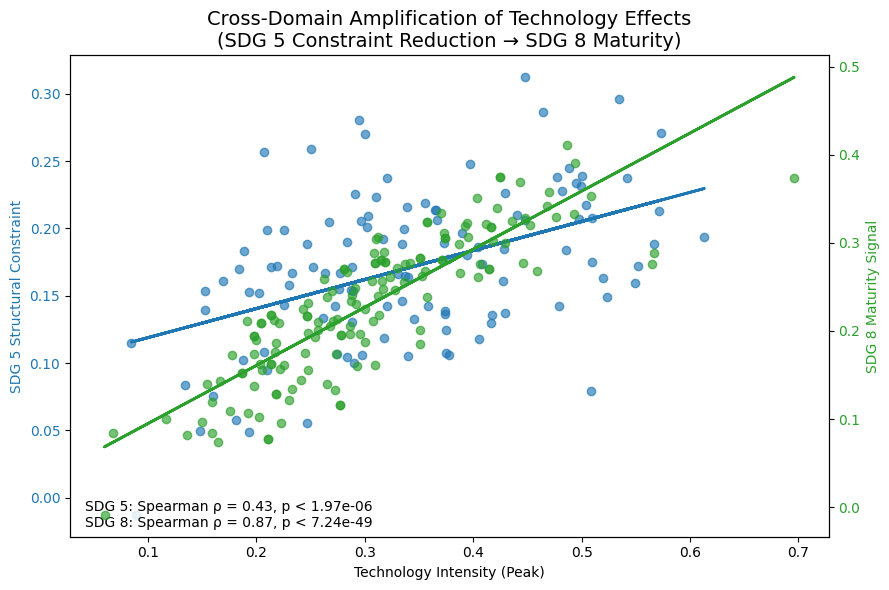

Saved figure to: /content/drive/MyDrive/Colab Notebooks/DTOSDG58//Figure_CrossDomain_Amplification.png


In [ ]:
# ============================================================
# FINAL FIGURE: Cross-Domain Amplification of Technology Effects
# SDG 5 (Constraints ↓)  |  SDG 8 (Maturity ↑)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# -----------------------------
# Paths
# -----------------------------
BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
DATA_FILE = f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv"
OUT_FIG = f"{BASE_OUT}/Figure_CrossDomain_Amplification.png"

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv(DATA_FILE)

# -----------------------------
# Define theory groups
# -----------------------------
TECH_THEORIES = ["TOE", "Dynamic Capabilities", "DigComp", "STS"]
CONSTRAINT_THEORIES = ["Just Digital", "Stakeholder", "Paradox"]
SDG8_THEORIES = ["TOE", "Dynamic Capabilities", "RBV"]

# -----------------------------
# Build analytical variables (data-driven)
# -----------------------------
df["Technology_Peak"] = df[[f"Score_{t}" for t in TECH_THEORIES]].max(axis=1)
df["SDG5_Constraint_v2"] = df[[f"Score_{t}" for t in CONSTRAINT_THEORIES]].mean(axis=1)
df["SDG8_Signal"] = df[[f"Score_{t}" for t in SDG8_THEORIES]].mean(axis=1)

# -----------------------------
# Split corpora
# -----------------------------
sdg5 = df[(df["SDG"] == "SDG5")].dropna(
    subset=["Technology_Peak", "SDG5_Constraint_v2"]
).copy()

sdg8 = df[(df["SDG"] == "SDG8")].dropna(
    subset=["Technology_Peak", "SDG8_Signal"]
).copy()

print("SDG5 docs:", sdg5.shape[0])
print("SDG8 docs:", sdg8.shape[0])

# -----------------------------
# Non-parametric statistics (for annotation)
# -----------------------------
rho5, p5 = spearmanr(sdg5["Technology_Peak"], sdg5["SDG5_Constraint_v2"])
rho8, p8 = spearmanr(sdg8["Technology_Peak"], sdg8["SDG8_Signal"])

# -----------------------------
# Plot: Dual-slope amplification figure
# -----------------------------
fig, ax_left = plt.subplots(figsize=(9, 6))

# --- Panel A: SDG5 (Constraints)
ax_left.scatter(
    sdg5["Technology_Peak"],
    sdg5["SDG5_Constraint_v2"],
    alpha=0.65,
    color="#1f77b4",
    label="SDG 5: Structural Constraints"
)
ax_left.set_xlabel("Technology Intensity (Peak)")
ax_left.set_ylabel("SDG 5 Structural Constraint", color="#1f77b4")
ax_left.tick_params(axis='y', labelcolor="#1f77b4")

# Visualization-only trend (no inferential claim)
z5 = np.polyfit(sdg5["Technology_Peak"], sdg5["SDG5_Constraint_v2"], 1)
ax_left.plot(
    sdg5["Technology_Peak"],
    np.poly1d(z5)(sdg5["Technology_Peak"]),
    color="#1f77b4",
    linewidth=2
)

# --- Panel B: SDG8 (Maturity)
ax_right = ax_left.twinx()
ax_right.scatter(
    sdg8["Technology_Peak"],
    sdg8["SDG8_Signal"],
    alpha=0.65,
    color="#2ca02c",
    label="SDG 8: Maturity Signal"
)
ax_right.set_ylabel("SDG 8 Maturity Signal", color="#2ca02c")
ax_right.tick_params(axis='y', labelcolor="#2ca02c")

# Visualization-only trend (no inferential claim)
z8 = np.polyfit(sdg8["Technology_Peak"], sdg8["SDG8_Signal"], 1)
ax_right.plot(
    sdg8["Technology_Peak"],
    np.poly1d(z8)(sdg8["Technology_Peak"]),
    color="#2ca02c",
    linewidth=2
)

# -----------------------------
# Title and annotation
# -----------------------------
plt.title(
    "Cross-Domain Amplification of Technology Effects\n"
    "(SDG 5 Constraint Reduction → SDG 8 Maturity)",
    fontsize=14
)

ax_left.text(
    0.02, 0.02,
    f"SDG 5: Spearman ρ = {rho5:.2f}, p < {p5:.3g}\n"
    f"SDG 8: Spearman ρ = {rho8:.2f}, p < {p8:.3g}",
    transform=ax_left.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
)

plt.tight_layout()
plt.savefig(OUT_FIG, dpi=300)
plt.show()

print("Saved figure to:", OUT_FIG)

In [ ]:
import pandas as pd
import numpy as np

BASE_OUT = "/content/drive/MyDrive/Colab Notebooks/DTOSDG58/"
df = pd.read_csv(f"{BASE_OUT}/DT_Theory_by_SDG_from_Filename.csv")

print(df.shape)
df.head()

(269, 13)


File   SDG    Dominant_DT_Theory  Score_TOE  Score_TAM  \
0  SDG8_003.docx  SDG8  Dynamic Capabilities   0.150772   0.095876   
1  SDG8_005.docx  SDG8                   TOE   0.392667   0.256806   
2  SDG8_008.docx  SDG8  Dynamic Capabilities   0.065701   0.093956   
3  SDG8_009.docx  SDG8                   RBV   0.280677   0.257417   
4  SDG8_010.docx  SDG8                   RBV   0.213892   0.160783   

   Score_UTAUT  Score_Dynamic Capabilities  Score_RBV  Score_STS  \
0     0.066254                    0.214053   0.124091   0.174199   
1     0.306468                    0.344349   0.221807   0.293295   
2     0.062746                    0.159525   0.131517   0.087841   
3     0.222686                    0.219277   0.309437   0.277103   
4     0.134898                    0.199397   0.241720   0.151346   

   Score_DigComp  Score_Just Digital  Score_Stakeholder  Score_Paradox  
0       0.198795            0.116218           0.036695       0.058481  
1       0.262972            0.203685           0.103734       0.100092  
2       0.074816            0.094883          -0.037415       0.041588  
3       0.217603            0.114197           0.183729       0.099002  
4       0.174116            0.218336           0.139580       0.179920

In [ ]:
TECH_THEORIES = [
    "TOE",
    "Dynamic Capabilities",
    "STS",
    "DigComp"
]

SDG5_NORMATIVE = [
    "Just Digital",
    "Stakeholder",
    "Paradox"
]

SDG8_ECONOMIC = [
    "TOE",
    "Dynamic Capabilities",
    "RBV"
]

In [ ]:
tech_cols = [f"Score_{t}" for t in TECH_THEORIES]

df["Technology_Peak"] = df[tech_cols].max(axis=1)

In [ ]:
norm_cols = [f"Score_{t}" for t in SDG5_NORMATIVE]

df["SDG5_Constraint_v2"] = np.nan

mask5 = df["SDG"] == "SDG5"
df.loc[mask5, "SDG5_Constraint_v2"] = (
    1 - df.loc[mask5, norm_cols].mean(axis=1)
)

In [ ]:
econ_cols = [f"Score_{t}" for t in SDG8_ECONOMIC]

df["SDG8_Signal"] = np.nan

mask8 = df["SDG"] == "SDG8"
df.loc[mask8, "SDG8_Signal"] = (
    df.loc[mask8, econ_cols].mean(axis=1)
)

In [ ]:
plot_df = df[[
    "Technology_Peak",
    "SDG5_Constraint_v2",
    "SDG8_Signal"
]].dropna()

print("Documents used:", plot_df.shape[0])
plot_df.describe()

Documents used: 0


Technology_Peak  SDG5_Constraint_v2  SDG8_Signal
count              0.0                 0.0          0.0
mean               NaN                 NaN          NaN
std                NaN                 NaN          NaN
min                NaN                 NaN          NaN
25%                NaN                 NaN          NaN
50%                NaN                 NaN          NaN
75%                NaN                 NaN          NaN
max                NaN                 NaN          NaN